In [1]:
%reload_ext autoreload
%autoreload 2

import torch
from tqdm import tqdm
from torch.utils.data import DataLoader
from pathlib import Path
from data import SimpleDataset, CellImageDataset
import seaborn as sns
import pandas as pd
from sklearn import mixture
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from scipy.special import softmax
from torchvision.utils import make_grid
from matplotlib import pyplot as plt
from microfilm.colorify import multichannel_to_rgb
from sklearn.cluster import AgglomerativeClustering
import multiscale_phate
import scprep

In [2]:
imsize = 512
batch_size = 10
# DATA_DIR = Path("./dev-dataset-FUCCI/")
# DATA_DIR = Path("/data/ishang/FUCCI-data/")
DATA_DIR = Path("/data/ishang/FUCCI-dataset-well/")
# NAME = "native_res_512_min_max"
# NAME = "native_res_512_min_max_low_sharp"
NAME = "well_spline_norm_512_crop_sharpness_1250"

In [3]:

# RGB_DATASET = DATA_DIR / "rgb_native_res_512_min_max.pt"
# dataset = SimpleDataset(path=RGB_DATASET)
# dataset = CellImageDataset(DATA_DIR / "index_rgb_native_res_512_min_max.csv", channel_colors=["pure_blue", "pure_yellow", "pure_green", "pure_red"])

dataset = CellImageDataset(DATA_DIR / f"index_{NAME}.csv", channel_colors=["pure_blue", "pure_yellow", "pure_green", "pure_red"], batch_size=batch_size)


Loading dataset images: 100%|██████████| 15/15 [02:52<00:00, 11.50s/it]


Loaded 33933 images from 142 files.


In [4]:
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)

# OLD PSEUDOTIMEEEE

In [ ]:
FUCCI_mean_intensities = []
for batch in tqdm(iter(dataloader), desc="Computing mean intensities"):
    FUCCI_mean_intensities.append(torch.mean(batch[:, 2:], dim=(2, 3)))
FUCCI_mean_intensities = torch.cat(FUCCI_mean_intensities, dim=0)

In [ ]:
print(torch.isnan(FUCCI_mean_intensities).sum())
print(torch.log10(torch.min(FUCCI_mean_intensities[torch.nonzero(FUCCI_mean_intensities[:, 0]), 0])))
print(torch.log10(torch.min(FUCCI_mean_intensities[torch.nonzero(FUCCI_mean_intensities[:, 1]), 1])))
print(len(FUCCI_mean_intensities))

In [ ]:
log_min = torch.tensor([10 ** (-5.4), 10 ** (-5)])
FUCCI_log_mean_intensities = torch.log10(FUCCI_mean_intensities + (~(FUCCI_mean_intensities > 0)) * log_min)
print(torch.min(FUCCI_log_mean_intensities[torch.nonzero(FUCCI_log_mean_intensities[:, 0]), 0]))
print(torch.min(FUCCI_log_mean_intensities[torch.nonzero(FUCCI_log_mean_intensities[:, 1]), 1]))
print(torch.max(FUCCI_log_mean_intensities[torch.nonzero(FUCCI_log_mean_intensities[:, 0]), 0]))
print(torch.max(FUCCI_log_mean_intensities[torch.nonzero(FUCCI_log_mean_intensities[:, 1]), 1]))
print(torch.isnan(FUCCI_log_mean_intensities).sum())
print(len(FUCCI_log_mean_intensities))

In [ ]:
pseudo_time_df = pd.DataFrame(FUCCI_log_mean_intensities.numpy(), columns=['GMNN', 'CDT1'])
sns.jointplot(data=pseudo_time_df, x='GMNN', y='CDT1', kind='kde')

Here GMNN has 10^4-fold meaningful range, whereas CDT1 has about 10^3-fold.

In [ ]:
# FUCCI_log_mean_intensities_rescaled = FUCCI_log_mean_intensities * torch.tensor([1.0, 4/3])
# pseudo_time_df = pd.DataFrame(FUCCI_log_mean_intensities_rescaled.numpy(), columns=['GMNN', 'CDT1'])
# sns.jointplot(data=pseudo_time_df, x='GMNN', y='CDT1', kind='kde')

In [ ]:
sns.kdeplot(data=pseudo_time_df, x='GMNN', y='CDT1')
outliers_index = ((pseudo_time_df['GMNN'] < -2.6) & (pseudo_time_df['CDT1'] < -2.7) | (pseudo_time_df['GMNN'] < -4.5) | (pseudo_time_df['CDT1'] < -4))
outlier = pseudo_time_df[outliers_index]
sns.scatterplot(data=outlier, x='GMNN', y='CDT1')

In [ ]:
print(np.sum(outliers_index) / len(outliers_index))
print(torch.min(FUCCI_log_mean_intensities[:, 0]), torch.max(FUCCI_log_mean_intensities[:, 0]))
print(torch.min(FUCCI_log_mean_intensities[:, 1]), torch.max(FUCCI_log_mean_intensities[:, 1]))

So 3.36% of the data is outside the range we really see in the KDE plots

In [ ]:
# cdts = range(-1, -8, -0.5) # so the grid with go top to bottom,
cdts = np.linspace(-0.3, -5, 20)
# gmmns = range(-5, 0, 0.5) # left to right
gmnns = np.linspace(-5.3, -0.3, 20)
nrow = len(gmnns)
images = []
blanks = 0
for cdt in cdts:
    for gmnn in gmnns:
        # find the image closest to this point in the intensity space
        point = torch.tensor([gmnn, cdt])
        distances = torch.sum((FUCCI_log_mean_intensities - point) ** 2, dim=1)
        closest = torch.argmin(distances)
        # if the closest is within 0.1, then we can use it, else just add a blank image
        if distances[closest] > ((0.5 * (gmnns[1] - gmnns[0])) ** 2 + (0.5 * (cdts[1] - cdts[0])) ** 2):
            images.append(torch.zeros_like(dataset[closest]))
            blanks += 1
        else:
            images.append(dataset[closest])

print(len(images))
print(blanks)
print(images[0].shape)


grid = make_grid(images, nrow=nrow)
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid, _, _, _ = multichannel_to_rgb(grid.cpu().numpy(), cmaps=cmaps)
plt.figure(figsize=(15, 15))
plt.imshow(grid)

In [ ]:
grid = make_grid(images, nrow=nrow)
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid, _, _, _ = multichannel_to_rgb(grid[2:].cpu().numpy(), cmaps=cmaps[2:])
plt.figure(figsize=(15, 15))
plt.imshow(grid)

In [ ]:
grid = make_grid(images, nrow=nrow)
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid, _, _, _ = multichannel_to_rgb(grid[:2].cpu().numpy(), cmaps=cmaps[:2])
plt.figure(figsize=(15, 15))
plt.imshow(grid)

![pseudotime](./pseudotime.png)

Based on this the phases of the cell in these data are:

Top Left Mode: G1

Middle Mode: G1/S

Top Right Top: S

Top Right Bottom: G2

Dead Bottom (minimum CDT): M

In [ ]:
n_components, prior = 4, 1e-5
indices = torch.randperm(len(FUCCI_log_mean_intensities))
X_train = FUCCI_log_mean_intensities[indices[:len(indices) // 2]]
X_pred = FUCCI_log_mean_intensities[indices[len(indices) // 2:]]
clf_cc = mixture.BayesianGaussianMixture(n_components=n_components, n_init=10, covariance_type="full", init_params="k-means++",
                                                  weight_concentration_prior=prior)
# from sklearn.decomposition import NMF
# nmf = NMF(n_components=2)
# X_train_nmf = nmf.fit_transform(X_train * -1)
# clf_cc_3_weight.fit(X_train_nmf)
clf_cc.fit(X_train)
y = clf_cc.predict(X_train)
sns.kdeplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

In [ ]:
# sns.jointplot(x=X_train_nmf[:, 0], y=X_train_nmf[:, 1], hue=y, palette="Set2")

In [ ]:
sns.jointplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

In [ ]:
w = clf_cc.weights_
print(w[1], w[2], w[0], w[3])

In [ ]:
from sklearn.cluster import AgglomerativeClustering
clustering = AgglomerativeClustering(n_clusters=6).fit(X_train)
sns.jointplot(x=X_train[:,0], y=X_train[:,1], hue=clustering.labels_, palette="Set2")

In [ ]:
order = [4, 2, 0, 5, 1, 3]
for i in order:
    print(np.sum(clustering.labels_ == i) / len(clustering.labels_))

In [ ]:
y = clf_cc.predict(X_pred)
sns.kdeplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y, palette="Set2")

![pseudoints](./pseudo_ints.png)
![system](./system.png)

From the images below, we might expect the following proportions:

M: 3; M/G1:6 + G1: 29; G1/S: 7; S:16, G2: 15

So M: 3; G1:35; S:23; G2:15 or 4%, 45%, 30%, 20% (which makes sense given the breakdown above)

That means the GMM above primarily over-estimates S and underestimates G1, which is strangely paralleled by the DINO model

![progpics](./prog_pics.png)

In [ ]:
clf_cc = mixture.GaussianMixture(n_components=3, weights_init=(0.5, 0.3, 0.2), n_init=10, covariance_type="full", init_params="k-means++")
clf_cc.fit(X_train)
y = clf_cc.predict(X_train)
sns.kdeplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

In [ ]:
y = clf_cc.predict_proba(X_pred)
y = y / np.sum(y, axis=-1, keepdims=True)
# y = softmax(y / 3, axis=-1)
plt.scatter(X_pred[:10000, 0], X_pred[:10000, 1], c=y[:10000])

In [ ]:
indices = torch.randperm(len(FUCCI_log_mean_intensities))
X_train = FUCCI_log_mean_intensities[indices[:len(indices) // 2]]
clf_cc_5 = mixture.GaussianMixture(n_components=5, covariance_type="full", init_params="k-means++")
clf_cc_5.fit(X_train)
X_pred = FUCCI_log_mean_intensities[indices[len(indices) // 2:]]
y = clf_cc_5.predict(X_train)
sns.kdeplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

# Pseudotime Component Extraction Rewrite

In [5]:
# Gather intensity and non-zero pixel counts
intensity_sums, non_zero_pixel_ct = [], []
for batch in tqdm(iter(dataloader), desc="Computing mean intensities"):
    intensity_sums.append(torch.sum(batch, dim=(2, 3)))
    non_zero_pixel_ct.append(torch.sum(batch > 0, dim=(2, 3)))
intensity_sums = torch.cat(intensity_sums, dim=0)
non_zero_pixel_ct = torch.cat(non_zero_pixel_ct, dim=0)

Computing mean intensities: 100%|██████████| 3394/3394 [02:29<00:00, 22.75it/s]


In [6]:
print(intensity_sums.shape)
print(non_zero_pixel_ct.shape)

torch.Size([33933, 4])
torch.Size([33933, 4])


In [7]:
# calculate epsilon for each term
def two_sig_fig_floor(x):
    return torch.floor(x / torch.pow(10.0, torch.floor(torch.log10(x)) - 1)) * torch.pow(10.0, torch.floor(torch.log10(x)) - 1)

non_zero_cells = intensity_sums > 0
epsilon_int, epsilon_ct = [], []
for i in range(intensity_sums.shape[1]):
    epsilon_int.append(two_sig_fig_floor(torch.min(intensity_sums[non_zero_cells[:, i], i])))
    epsilon_ct.append(two_sig_fig_floor(torch.min(non_zero_pixel_ct[non_zero_cells[:, i], i])))

In [8]:
print(epsilon_int)
print(epsilon_ct)

[tensor(15.), tensor(1.5000), tensor(0.1700), tensor(1.1000)]
[tensor(2000.), tensor(470.), tensor(100.), tensor(180.)]


In [6]:
import pickle as pkl
intensity_data = {"intensity_sums": intensity_sums, "non_zero_pixel_ct": non_zero_pixel_ct, "epsilon_int": epsilon_int, "epsilon_ct": epsilon_ct}
with open(DATA_DIR / "intensity_data.pkl", "wb") as f:
    pkl.dump(intensity_data, f)

NameError: name 'intensity_sums' is not defined

In [4]:
import pickle as pkl
intensity_data = pkl.load(open(DATA_DIR / "intensity_data.pkl", "rb"))
intensity_sums = intensity_data["intensity_sums"]
non_zero_pixel_ct = intensity_data["non_zero_pixel_ct"]
epsilon_int = intensity_data["epsilon_int"]
epsilon_ct = intensity_data["epsilon_ct"]

In [5]:
log_intensities = torch.log10(intensity_sums + (~(intensity_sums > 0)) * torch.tensor(epsilon_int))
log_mean_intensities = log_intensities - torch.log10(non_zero_pixel_ct + (~(non_zero_pixel_ct > 0)) * torch.tensor(epsilon_ct))

In [6]:
channel_names = ["DAPI", "TUBL", "GMNN", "CDT1"]
df_total = pd.DataFrame({channel_names[i]: log_intensities[:, i] for i in range(len(channel_names))})
df_mean = pd.DataFrame({channel_names[i]: log_mean_intensities[:, i] for i in range(len(channel_names))})

In [7]:
fucci_time = np.load(DATA_DIR / f"FUCCI_pseudotime_{NAME}.npy")
pred_time = np.load(DATA_DIR / f"FUCCI_pseudotime_pred_{NAME}.npy")
bins = np.linspace(0, 1, 201)
fucci_time_binned = (np.digitize(fucci_time, bins) - 1) / 200
pred_time_binned = (np.digitize(pred_time, bins) - 1) / 200

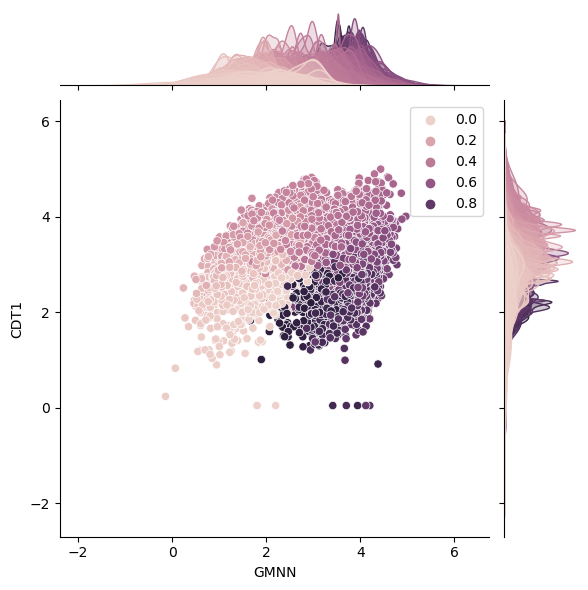

<Figure size 640x480 with 0 Axes>

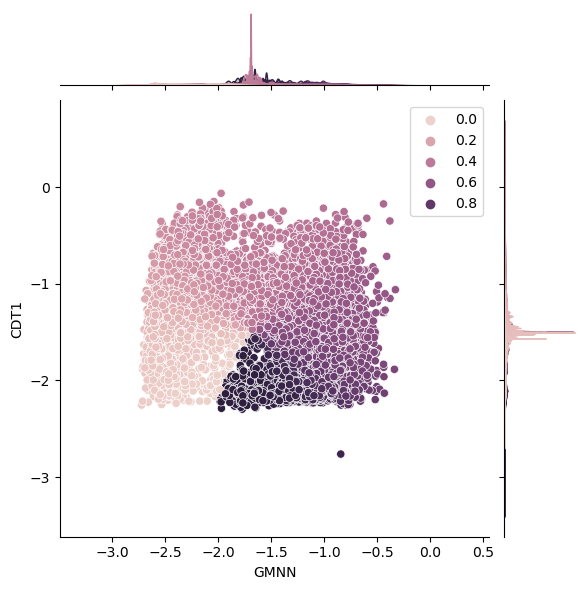

In [8]:
# plot samples
samples = np.random.choice(len(df_total), 10000)
sns.jointplot(data=df_total.iloc[samples], x="GMNN", y="CDT1", hue=fucci_time[samples])
plt.show()
plt.clf()
sns.jointplot(data=df_mean.iloc[samples], x="GMNN", y="CDT1", hue=fucci_time[samples])

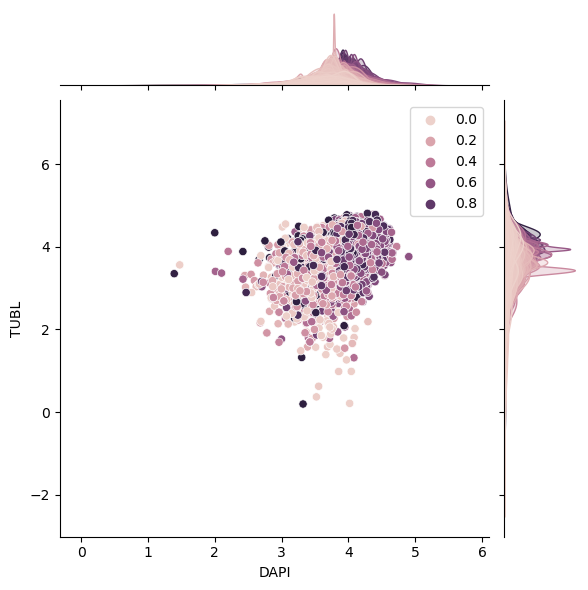

<Figure size 640x480 with 0 Axes>

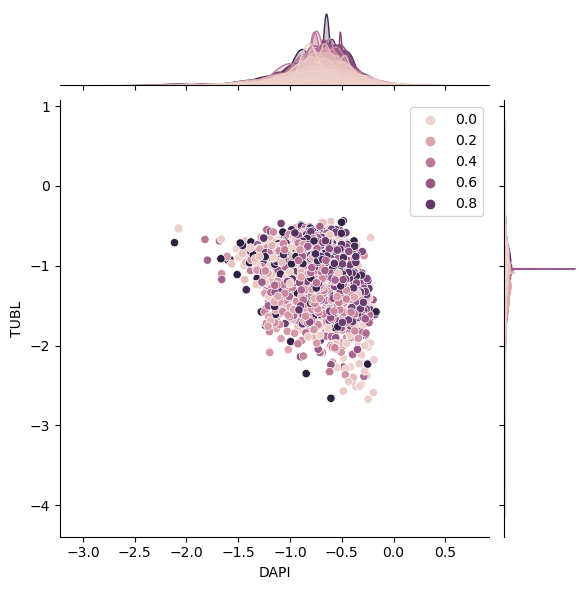

In [9]:
sns.jointplot(data=df_total.iloc[samples], x="DAPI", y="TUBL", hue=fucci_time[samples])
plt.show()
plt.clf()
sns.jointplot(data=df_mean.iloc[samples], x="DAPI", y="TUBL", hue=fucci_time[samples])

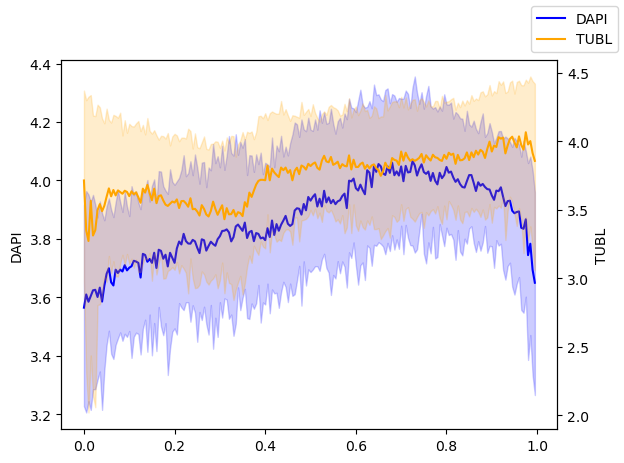

In [18]:
# plot DAPI and TUBL vs FUCCI time
ci = False
interval = 75
ax = sns.lineplot(data=df_total, x=fucci_time_binned, y="DAPI", errorbar=('ci' if ci else 'pi', interval), color="blue", label="DAPI", legend=False)
ax2 = ax.twinx()
sns.lineplot(data=df_total, x=fucci_time_binned, y="TUBL", errorbar=('ci' if ci else 'pi', interval), color="orange", label="TUBL", legend=False)
# plt.ylabel("Mean intensity")
plt.xlabel("FUCCI pseudotime")
ax.figure.legend()
plt.show()

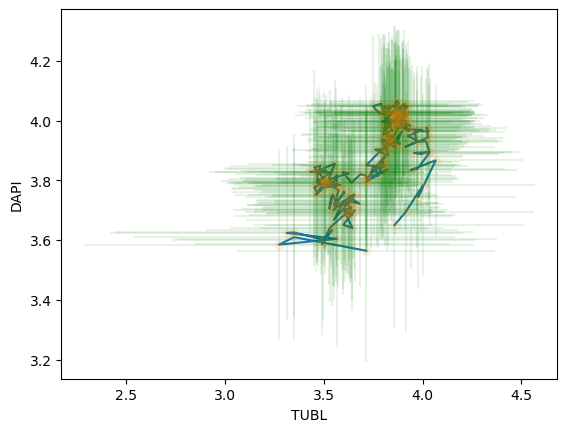

In [11]:
# plot the timeseries means as a jointplot in normalized coordinates
TUBL_ts = df_total.groupby(fucci_time_binned)["TUBL"].mean()
DAPI_ts = df_total.groupby(fucci_time_binned)["DAPI"].mean()
TUBL_ts_error = df_total.groupby(fucci_time_binned)["TUBL"].std()
DAPI_ts_error = df_total.groupby(fucci_time_binned)["DAPI"].std()
plt.plot(TUBL_ts, DAPI_ts)

# fill a circle with the error bars at each point, but make them transparent
plt.errorbar(TUBL_ts, DAPI_ts, xerr=TUBL_ts_error, yerr=DAPI_ts_error, fmt='o', ecolor='g', capthick=2, alpha=0.1)

plt.xlabel("TUBL")
plt.ylabel("DAPI")
plt.show()

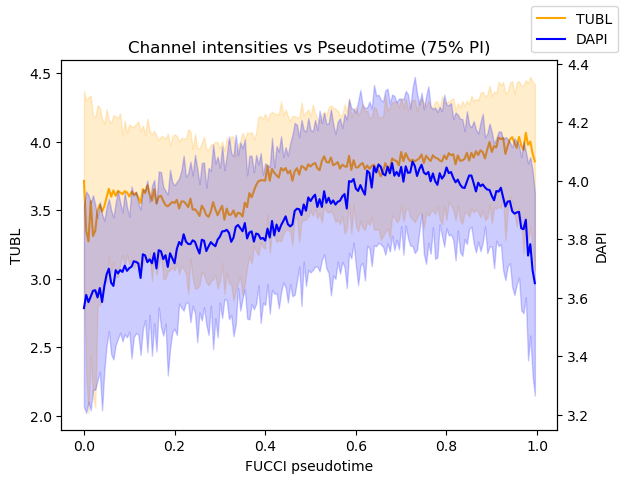

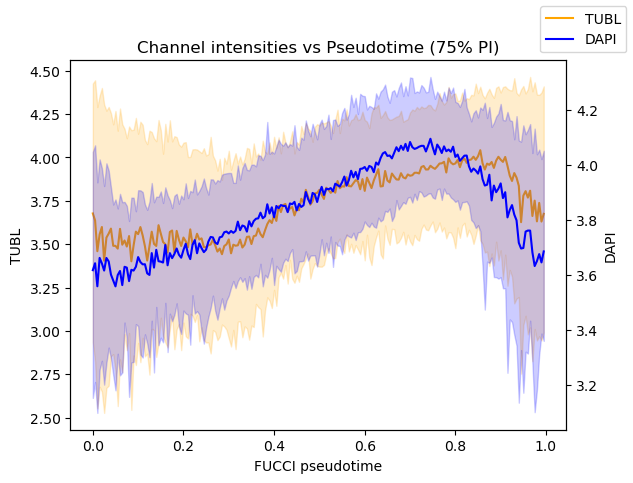

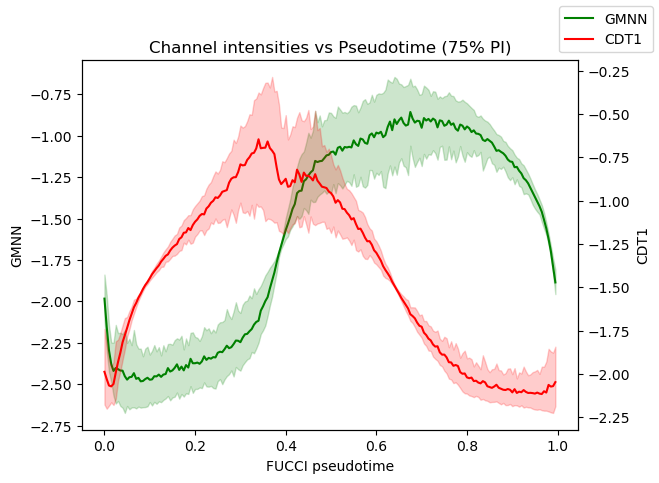

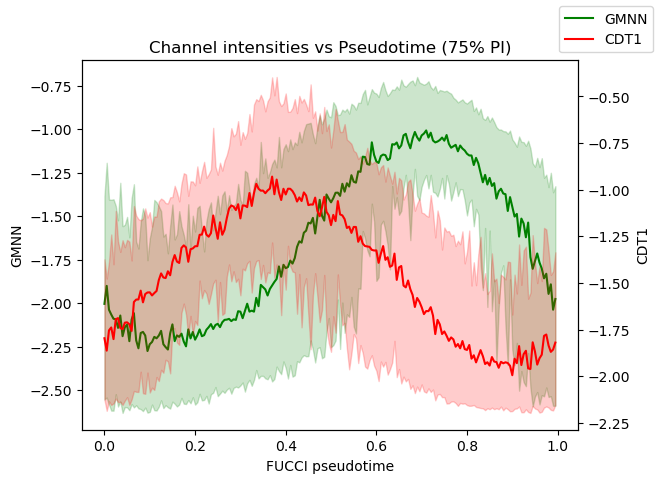

In [37]:
def plot_intensity_pseudotime(df1, df2, pseudotime, ch1, ch2, color1, color2, model=False):
    plt.clf()
    ax = sns.lineplot(data=df1, x=pseudotime, y=ch1, errorbar=('ci' if ci else 'pi', interval), color=color1, label=ch1, legend=False)
    ax2 = ax.twinx()
    sns.lineplot(data=df2, x=pseudotime, y=ch2, errorbar=('ci' if ci else 'pi', interval), color=color2, label=ch2, legend=False)
    plt.title(f"Channel intensities vs {'Model ' if model else ''}Pseudotime ({interval}% {'CI' if ci else 'PI'})")
    ax.set_xlabel("Model pseudotime" if model else "FUCCI pseudotime")
    ax.figure.legend()
    plt.show()

plot_intensity_pseudotime(df_total, df_total, fucci_time_binned, "TUBL", "DAPI", "orange", "blue")
plot_intensity_pseudotime(df_total, df_total, pred_time_binned, "TUBL", "DAPI", "orange", "blue", model=True)
plot_intensity_pseudotime(df_mean, df_mean, fucci_time_binned, "GMNN", "CDT1", "green", "red")
plot_intensity_pseudotime(df_mean, df_mean, pred_time_binned, "GMNN", "CDT1", "green", "red", model=True)

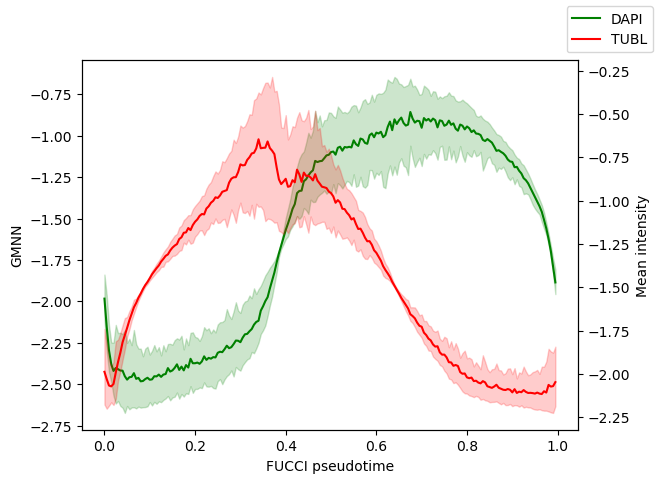

In [26]:
ax = sns.lineplot(data=df_mean, x=fucci_time_binned, y="GMNN", errorbar=('ci' if ci else 'pi', interval), color="green", label="DAPI", legend=False)
ax2 = ax.twinx()
sns.lineplot(data=df_mean, x=fucci_time_binned, y="CDT1", errorbar=('ci' if ci else 'pi', interval), color="red", label="TUBL", legend=False)
plt.ylabel("Mean intensity")
ax.set_xlabel("FUCCI pseudotime")
ax.figure.legend()
plt.show()

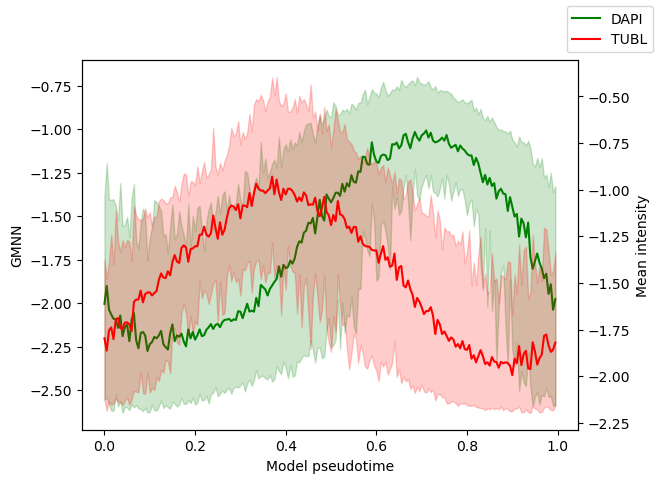

In [25]:
ax = sns.lineplot(data=df_mean, x=pred_time_binned, y="GMNN", errorbar=('ci' if ci else 'pi', interval), color="green", label="DAPI", legend=False)
ax2 = ax.twinx()
sns.lineplot(data=df_mean, x=pred_time_binned, y="CDT1", errorbar=('ci' if ci else 'pi', interval), color="red", label="TUBL", legend=False)
plt.ylabel("Mean intensity")
ax.set_xlabel("Model pseudotime")
ax.figure.legend()
plt.show()

# NEW PSEUDOTIME METHOD HEREEERERERE

In [13]:
FUCCI_nonzero_pixel_ct = []
FUCCI_intensity_sums = []
for batch in tqdm(iter(dataloader), desc="Computing mean intensities"):
    FUCCI_intensity_sums.append(torch.sum(batch[:, 2:], dim=(2, 3)))
    FUCCI_nonzero_pixel_ct.append(torch.sum(batch[:, 2:] > 0, dim=(2, 3)))
FUCCI_intensity_sums = torch.cat(FUCCI_intensity_sums, dim=0)
FUCCI_nonzero_pixel_ct = torch.cat(FUCCI_nonzero_pixel_ct, dim=0)

Computing mean intensities:  48%|████▊     | 1635/3394 [00:54<00:58, 29.83it/s]


KeyboardInterrupt: 

In [17]:
FUCCI_intensity_sums = intensity_sums[:, 2:]
FUCCI_nonzero_pixel_ct = non_zero_pixel_ct[:, 2:]

In [18]:

print("Number of nonzero cells, min/max for GMNN and CDT1")
print(torch.min(FUCCI_nonzero_pixel_ct[:, 0]), torch.max(FUCCI_nonzero_pixel_ct[:, 0]))
print(torch.min(FUCCI_nonzero_pixel_ct[:, 1]), torch.max(FUCCI_nonzero_pixel_ct[:, 1]))

print("\nNumber of nonzero cells, min with and min without looking at images with 0 nonzero pixels for GMNN and CDT1")
nonzero_0 = FUCCI_nonzero_pixel_ct[:, 0].nonzero().flatten()
nonzero_1 = FUCCI_nonzero_pixel_ct[:, 1].nonzero().flatten()

print(torch.min(FUCCI_nonzero_pixel_ct[nonzero_0, 0]), torch.min(FUCCI_nonzero_pixel_ct[:, 0]))
print(torch.min(FUCCI_nonzero_pixel_ct[nonzero_1, 1]), torch.min(FUCCI_nonzero_pixel_ct[:, 1]))
FUCCI_nonzero_ct_eps = torch.tensor([torch.min(FUCCI_nonzero_pixel_ct[nonzero_0, 0]), torch.min(FUCCI_nonzero_pixel_ct[nonzero_1, 1])])
FUCCI_nonzero_ct_eps = two_sig_fig_floor(FUCCI_nonzero_ct_eps)
print("eps: ", FUCCI_nonzero_ct_eps)

print("\nIntensity of nonzero cells, min/max for GMNN and CDT1")
print(torch.min(FUCCI_intensity_sums[:, 0]), torch.max(FUCCI_intensity_sums[:, 0]))
print(torch.min(FUCCI_intensity_sums[:, 1]), torch.max(FUCCI_intensity_sums[:, 1]))

print("\nIntensity of nonzero cells, min and min without looking at images with 0 nonzero pixels for GMNN and CDT1")
nonzero_0 = FUCCI_intensity_sums[:, 0].nonzero().flatten()
nonzero_1 = FUCCI_intensity_sums[:, 1].nonzero().flatten()

print(torch.min(FUCCI_intensity_sums[nonzero_0, 0]), torch.min(FUCCI_intensity_sums[:, 0]))
print(torch.min(FUCCI_intensity_sums[nonzero_1, 1]), torch.min(FUCCI_intensity_sums[:, 1]))
FUCCI_sum_eps = torch.tensor([torch.min(FUCCI_intensity_sums[nonzero_0, 0]), torch.min(FUCCI_intensity_sums[nonzero_1, 1])])
FUCCI_sum_eps = two_sig_fig_floor(FUCCI_sum_eps)
print("eps: ", FUCCI_sum_eps)

Number of nonzero cells, min/max for GMNN and CDT1
tensor(103) tensor(260610)
tensor(0) tensor(229881)

Number of nonzero cells, min with and min without looking at images with 0 nonzero pixels for GMNN and CDT1
tensor(103) tensor(103)
tensor(182) tensor(0)
eps:  tensor([100., 180.])

Intensity of nonzero cells, min/max for GMNN and CDT1
tensor(0.1779) tensor(104374.0469)
tensor(0.) tensor(98408.4141)

Intensity of nonzero cells, min and min without looking at images with 0 nonzero pixels for GMNN and CDT1
tensor(0.1779) tensor(0.1779)
tensor(1.1186) tensor(0.)
eps:  tensor([0.1700, 1.1000])


In [ ]:
FUCCI_log_mean_intensities_nonzero = torch.log10((FUCCI_intensity_sums + FUCCI_sum_eps) / (FUCCI_nonzero_pixel_ct + FUCCI_nonzero_ct_eps))
for i in range(FUCCI_log_mean_intensities_nonzero.shape[1]):
    print(len(FUCCI_log_mean_intensities_nonzero[torch.isnan(FUCCI_log_mean_intensities_nonzero[:, i])]),
        FUCCI_log_mean_intensities_nonzero[torch.isnan(FUCCI_log_mean_intensities_nonzero[:, i])][:10, i])
    print(len(FUCCI_log_mean_intensities_nonzero[torch.isinf(FUCCI_log_mean_intensities_nonzero[:, i])]),
        FUCCI_log_mean_intensities_nonzero[torch.isinf(FUCCI_log_mean_intensities_nonzero[:, i])][:10, i])
print(torch.min(FUCCI_log_mean_intensities_nonzero[:, 0]), torch.max(FUCCI_log_mean_intensities_nonzero[:, 0]))
print(torch.min(FUCCI_log_mean_intensities_nonzero[:, 1]), torch.max(FUCCI_log_mean_intensities_nonzero[:, 1]))

In [ ]:
pseudo_time_df = pd.DataFrame(FUCCI_log_mean_intensities_nonzero.numpy(), columns=['GMNN', 'CDT1'])
sns.jointplot(data=pseudo_time_df, x='GMNN', y='CDT1', kind="kde")

In [ ]:
# write the intensity labels to file

np.save(DATA_DIR / f"FUCCI_log_intensity_labels_{NAME}.npy", FUCCI_log_mean_intensities_nonzero.numpy())

In [ ]:
size_path = DATA_DIR / f"FUCCI_log_intensity_labels_and_size_{NAME}.pt"
if size_path.exists():
    fucci_and_size = torch.load(size_path)
    print("Loaded", fucci_and_size.shape)
else:
    fucci_and_size = torch.cat([FUCCI_log_mean_intensities_nonzero, FUCCI_nonzero_pixel_ct], dim=1)
    torch.save(fucci_and_size, size_path)
    print(fucci_and_size.shape)

sample_indices = np.random.choice(len(fucci_and_size), 1000)

fucci_and_size[:, 2] = torch.where(fucci_and_size[:, 2] > fucci_and_size[:, 3], fucci_and_size[:, 2], fucci_and_size[:, 3])
fucci_and_size = fucci_and_size[:, :3]

# plot in 3D
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget
plt.clf()
fig = plt.figure(figsize=(10, 10))
# ax = Axes3D(fig)
ax = fig.add_subplot(111, projection='3d')
ax.xaxis.set_label_text('GMNN')
ax.yaxis.set_label_text('CDT1')
ax.zaxis.set_label_text('Size')
ax.scatter(fucci_and_size[sample_indices, 0], fucci_and_size[sample_indices, 1], fucci_and_size[sample_indices, 2])

In [ ]:
# similarly calculate intensities of input reference channels
REF_nonzero_pixel_ct = []
REF_intensity_sums = []
for batch in tqdm(iter(dataloader), desc="Computing mean intensities"):
    REF_intensity_sums.append(torch.sum(batch[:, :2], dim=(2, 3)))
    REF_nonzero_pixel_ct.append(torch.sum(batch[:, :2] > 0, dim=(2, 3)))
REF_intensity_sums = torch.cat(REF_intensity_sums, dim=0)
REF_nonzero_pixel_ct = torch.cat(REF_nonzero_pixel_ct, dim=0)

In [ ]:
nonzero_0 = REF_nonzero_pixel_ct[:, 0].nonzero().flatten()
nonzero_1 = REF_nonzero_pixel_ct[:, 1].nonzero().flatten()

REF_nonzero_ct_eps = torch.tensor([torch.min(REF_nonzero_pixel_ct[nonzero_0, 0]), torch.min(REF_nonzero_pixel_ct[nonzero_1, 1])])
REF_nonzero_ct_eps = two_sig_fig_floor(REF_nonzero_ct_eps)

nonzero_0 = REF_intensity_sums[:, 0].nonzero().flatten()
nonzero_1 = REF_intensity_sums[:, 1].nonzero().flatten()

REF_sum_eps = torch.tensor([torch.min(REF_intensity_sums[nonzero_0, 0]), torch.min(REF_intensity_sums[nonzero_1, 1])])
REF_sum_eps = two_sig_fig_floor(REF_sum_eps)

In [ ]:
REF_log_mean_intensities_nonzero = torch.log10((REF_intensity_sums + REF_sum_eps) / (REF_nonzero_pixel_ct + REF_nonzero_ct_eps))
for i in range(REF_log_mean_intensities_nonzero.shape[1]):
    print(len(REF_log_mean_intensities_nonzero[torch.isnan(REF_log_mean_intensities_nonzero[:, i])]),
        REF_log_mean_intensities_nonzero[torch.isnan(REF_log_mean_intensities_nonzero[:, i])][:10, i])
    print(len(REF_log_mean_intensities_nonzero[torch.isinf(REF_log_mean_intensities_nonzero[:, i])]),
        REF_log_mean_intensities_nonzero[torch.isinf(REF_log_mean_intensities_nonzero[:, i])][:10, i])
print(torch.min(REF_log_mean_intensities_nonzero[:, 0]), torch.max(REF_log_mean_intensities_nonzero[:, 0]))
print(torch.min(REF_log_mean_intensities_nonzero[:, 1]), torch.max(REF_log_mean_intensities_nonzero[:, 1]))

In [ ]:
# plot reference intensity sum against FUCCI intensity sum
plt.scatter(torch.sum(REF_log_mean_intensities_nonzero, dim=1), torch.sum(FUCCI_log_mean_intensities_nonzero, dim=1))
# add a line of best fit
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(torch.sum(REF_log_mean_intensities_nonzero, dim=1), torch.sum(FUCCI_log_mean_intensities_nonzero, dim=1))
print(slope, intercept, r_value, p_value, std_err)
plt.plot(torch.sum(REF_log_mean_intensities_nonzero, dim=1), intercept + slope * torch.sum(REF_log_mean_intensities_nonzero, dim=1), 'r', label='fitted line')

In [ ]:
# KDE plot of reference intensity sum against FUCCI intensity sum
sns.kdeplot(x=torch.sum(REF_log_mean_intensities_nonzero, dim=1), y=torch.sum(FUCCI_log_mean_intensities_nonzero, dim=1))

In [ ]:
FUCCI_intensity_sums_corrected = FUCCI_intensity_sums + FUCCI_sum_eps
REF_intensity_sums_corrected = REF_intensity_sums + REF_sum_eps
# plot reference intensity sum against FUCCI intensity sum
plt.scatter(torch.sum(REF_intensity_sums_corrected, dim=1), torch.sum(FUCCI_log_mean_intensities_nonzero, dim=1))
# add a line of best fit
from scipy.stats import linregress
slope, intercept, r_value, p_value, std_err = linregress(torch.sum(REF_intensity_sums_corrected, dim=1), torch.sum(FUCCI_log_mean_intensities_nonzero, dim=1))
print(slope, intercept, r_value, p_value, std_err)
plt.plot(torch.sum(REF_intensity_sums_corrected, dim=1), intercept + slope * torch.sum(REF_intensity_sums_corrected, dim=1), 'r', label='fitted line')

In [ ]:
# write reference intensities to file
np.save(DATA_DIR / f"REF_log_intensity_labels_{NAME}.npy", REF_log_mean_intensities_nonzero.numpy())

# PHATE

In [ ]:
def PHATE_fit(embeddings, sample=None, message=""):
    if isinstance(embeddings, torch.Tensor):
        embeddings = embeddings.numpy()
    if sample is not None:
        indices = np.random.choice(len(embeddings), sample)
        embeddings = embeddings[indices]
    mp_op = multiscale_phate.Multiscale_PHATE()
    return mp_op.fit_transform(embeddings)

def PHATE_plot(mp_embedding, mp_sizes, mp_clusters, message=""):
    scprep.plot.scatter2d(mp_embedding, s=mp_sizes, c=mp_clusters,
                          fontsize=16, ticks=False,label_prefix="Multiscale PHATE", figsize=(10, 10))

In [ ]:
phate_output = PHATE_fit(FUCCI_log_mean_intensities_nonzero, sample=1000)
PHATE_plot(*phate_output, message="")

In [ ]:
phate_output = PHATE_fit(FUCCI_log_mean_intensities_nonzero)
PHATE_plot(*phate_output, message="")

# Mosaic

In [ ]:
cdts = np.linspace(0.0, -3.0, 20) # so the grid with go top to bottom,
gmnns = np.linspace(-3.0, 0.0, 20) # left to right
nrow = len(gmnns)
images = []
blanks = 0
for cdt in cdts:
    for gmnn in gmnns:
        # find the image closest to this point in the intensity space
        point = torch.tensor([gmnn, cdt])
        distances = torch.sum((FUCCI_log_mean_intensities_nonzero - point) ** 2, dim=1)
        closest = torch.argmin(distances)
        # if the closest is within 0.1, then we can use it, else just add a blank image
        if distances[closest] > ((0.5 * (gmnns[1] - gmnns[0])) ** 2 + (0.5 * (cdts[1] - cdts[0])) ** 2):
            images.append(torch.zeros_like(dataset[closest]))
            blanks += 1
        else:
            images.append(dataset[closest])

print(len(images))
print(blanks)
print(images[0].shape)

grid = make_grid(images, nrow=nrow)
print(grid.shape)

In [ ]:
xlabels = np.round(gmnns[::2], 1)
xticks = (gmnns[::2] - np.min(gmnns)) / (np.max(gmnns) - np.min(gmnns)) * grid.shape[1]
print(xticks)
print(xlabels)
ylabels = np.round(cdts[::2], 1)
yticks = (cdts[::-2] - np.min(cdts)) / (np.max(cdts) - np.min(cdts)) * grid.shape[2]
print(yticks)
print(ylabels)

In [ ]:

cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid_rgb, _, _, _ = multichannel_to_rgb(grid.cpu().numpy(), cmaps=cmaps)

plt.figure(figsize=(15, 15))
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.imshow(grid_rgb)

In [ ]:
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid_rgb, _, _, _ = multichannel_to_rgb(grid[2:].cpu().numpy(), cmaps=cmaps[2:])
plt.figure(figsize=(15, 15))
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.imshow(grid_rgb)

In [ ]:
cmaps = ["pure_blue", "pure_yellow", "pure_green", "pure_red"]
grid_rgb, _, _, _ = multichannel_to_rgb(grid[:2].cpu().numpy(), cmaps=cmaps[:2])
plt.figure(figsize=(15, 15))
plt.xticks(xticks, xlabels)
plt.yticks(yticks, ylabels)
plt.imshow(grid_rgb)

# GMM

In [ ]:
n_components = 3
indices = torch.randperm(len(FUCCI_log_mean_intensities_nonzero))
X_train = FUCCI_log_mean_intensities_nonzero[indices[:len(indices) // 2]]
X_pred = FUCCI_log_mean_intensities_nonzero[indices[len(indices) // 2:]]
clf_cc = mixture.GaussianMixture(n_components=n_components, n_init=10, covariance_type="full", init_params="k-means++")
clf_cc.fit(X_train)
y = clf_cc.predict(X_pred)
sns.kdeplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y, palette="Set2")

In [ ]:
sns.jointplot(x=X_pred[:, 0], y=X_pred[:, 1], hue=y, palette="Set2")

In [ ]:
n_components, prior = 7, 1e-3
indices = torch.randperm(len(FUCCI_log_mean_intensities_nonzero))
X_train = FUCCI_log_mean_intensities_nonzero[indices[:len(indices) // 2]]
X_pred = FUCCI_log_mean_intensities_nonzero[indices[len(indices) // 2:]]
clf_cc = mixture.BayesianGaussianMixture(n_components=n_components, n_init=10, covariance_type="full", init_params="k-means++",
                                                  weight_concentration_prior=prior)
clf_cc.fit(X_train)
y = clf_cc.predict(X_train)
sns.kdeplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

In [ ]:
sns.jointplot(x=X_train[:, 0], y=X_train[:, 1], hue=y, palette="Set2")

In [ ]:
# import pickle
# GMM_FILE = DATA_DIR / "gmm.pkl"
# pickle.dump(clf_cc, open(GMM_FILE, "wb"))

In [ ]:
# clf_cc_pts = mixture.BayesianGaussianMixture(n_components=6, n_init=10, weight_concentration_prior=1e-4).fit(X_train)

# New datasets

In [ ]:
n_clusters = 4
clustering = AgglomerativeClustering(n_clusters=n_clusters)
clustering.fit(FUCCI_log_mean_intensities_nonzero)
y_pred = clustering.labels_


In [ ]:
sns.jointplot(x=FUCCI_log_mean_intensities_nonzero[:,0], y=FUCCI_log_mean_intensities_nonzero[:,1], hue=y_pred, palette='Set2')

# convert y_pred to torch tensor and write to DATA_DIR / "ward_probs_{name}.pt"
y_pred = torch.tensor(y_pred)
print(y_pred.shape)

print(torch.unique(y_pred))

In [ ]:
remap = [2, 1, 3, 0]
print(y_pred[:10])
y_pred_remapped = []
for i in range(len(y_pred)):
    y_pred_remapped.append(remap.index(y_pred[i]))
print(y_pred_remapped[:10])

In [ ]:
file_name = DATA_DIR / f"ward_{n_clusters}_probs_{NAME}.pt"
y_pred_remapped = torch.tensor(y_pred_remapped)
torch.save(y_pred_remapped, file_name)
print(f"Saved to {file_name}")

In [ ]:
# https://stackoverflow.com/questions/47873759/how-to-fit-a-2d-ellipse-to-given-points

# fit an ellipse to the means and plot
# print(clf_cc_pts.weights_)
# means = clf_cc_pts.means_
# means = np.concatenate((means, np.array([[-2.3, -2.3]])))


means = []
for i in range(n_clusters):
    print(FUCCI_log_mean_intensities_nonzero[clustering.labels_ == i, :].shape)
    means.append(torch.mean(FUCCI_log_mean_intensities_nonzero[clustering.labels_ == i, :], dim=0).cpu().numpy())
means = np.array(means)
means = np.concatenate((means, np.array([[-2.5, -2.3]])))

# Extract x coords and y coords of the ellipse as column vectors
X = means[:,0:1]
Y = means[:,1:2]
# X = X_train[:, 0:1]
# Y = X_train[:, 1:]

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.hstack([X**2, X * Y, Y**2, X, Y])
b = np.ones_like(X)
x = np.linalg.lstsq(A, b)[0].squeeze()

print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(x[0], x[1],x[2],x[3],x[4]))

x_coord = np.linspace(torch.min(FUCCI_log_mean_intensities_nonzero[:,0]),torch.max(FUCCI_log_mean_intensities_nonzero[:,0]),300)
y_coord = np.linspace(torch.min(FUCCI_log_mean_intensities_nonzero[:,1]),torch.max(FUCCI_log_mean_intensities_nonzero[:,1]),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
sns.jointplot(x=FUCCI_log_mean_intensities_nonzero[:, 0], y=FUCCI_log_mean_intensities_nonzero[:, 1], kind='kde', palette="Set2")
sns.scatterplot(x=means[:, 0], y=means[:, 1])
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

In [ ]:
gmnn_gmm = mixture.BayesianGaussianMixture(n_components=3, n_init=10, weight_concentration_prior=1e-4).fit(X_train[:, 0:1])
cdt_gmm = mixture.BayesianGaussianMixture(n_components=3, n_init=10, weight_concentration_prior=1e-4).fit(X_train[:, 1:2])

In [ ]:
gmnn_modes = np.stack([gmnn_gmm.means_.flatten(), gmnn_gmm.weights_.flatten()], axis=-1)
gmnn_modes = gmnn_modes[gmnn_modes[:, 0].argsort()]
cdt_modes = np.stack([cdt_gmm.means_.flatten(), cdt_gmm.weights_.flatten()], axis=-1)
cdt_modes = cdt_modes[cdt_modes[:, 0].argsort()]

In [ ]:
points = np.array([
    [0, 0],
    [0, 1],
    [1, 2],
    [1, 2],
    [2, 2],
    [2, 1],
    [2, 0],
])

key_points = np.asarray([[gmnn_modes[:, 0][i], cdt_modes[:, 0][j]] for (i, j) in points])
probs = np.asarray([[gmnn_modes[:, 1][i] * cdt_modes[:, 1][j] for j in range(3)] for i in range(3)])
key_probs = np.asarray([gmnn_modes[:, 1][i] * gmnn_modes[:, 1][j] for (i, j) in points])
key_probs = key_probs / np.sum(key_probs)
print(key_probs)

# https://stackoverflow.com/questions/47873759/how-to-fit-a-2d-ellipse-to-given-points

# Extract x coords and y coords of the ellipse as column vectors
X = key_points[:,0:1]
Y = key_points[:,1:]

# Formulate and solve the least squares problem ||Ax - b ||^2
A = np.hstack([X**2, X * Y, Y**2, X, Y])
b = np.ones_like(X)
x = np.linalg.lstsq(A, b)[0].squeeze()

print('The ellipse is given by {0:.3}x^2 + {1:.3}xy+{2:.3}y^2+{3:.3}x+{4:.3}y = 1'.format(x[0], x[1],x[2],x[3],x[4]))

x_coord = np.linspace(torch.min(X_train[:,0]),torch.max(X_train[:,0]),300)
y_coord = np.linspace(torch.min(X_train[:,1]),torch.max(X_train[:,1]),300)
X_coord, Y_coord = np.meshgrid(x_coord, y_coord)
Z_coord = x[0] * X_coord ** 2 + x[1] * X_coord * Y_coord + x[2] * Y_coord**2 + x[3] * X_coord + x[4] * Y_coord
sns.jointplot(x=X_train[:, 0], y=X_train[:, 1], kind='kde', palette="Set2")
sns.scatterplot(x=key_points[:, 0], y=key_points[:, 1])
plt.contour(X_coord, Y_coord, Z_coord, levels=[1], colors=('r'), linewidths=2)

# Model Prediction Breakdown

In [ ]:
from models import ClassifierLit
from data import DinoRefToCC
data_dir = DATA_DIR
data_name = NAME
ward = True
num_classes = 4
dino_ds = DinoRefToCC(data_dir, data_name, ward, num_classes)


In [ ]:
phate_output = PHATE_fit(dino_ds[:1000][0])
PHATE_plot(*phate_output, message="")

In [ ]:
phate_output = PHATE_fit(dino_ds[:10000][0])
PHATE_plot(*phate_output, message="")

In [ ]:
phate_output = PHATE_fit(dino_ds[:][0])
PHATE_plot(*phate_output, message="")

In [ ]:
import umap
import umap.plot

indices = np.random.choice(len(dino_ds), 5000, replace=False)
embeddings, ps_labels = dino_ds[indices]
ps_labels = torch.argmax(ps_labels, dim=-1).flatten()
umap_embedding = umap.UMAP().fit(embeddings)
umap.plot.points(umap_embedding, labels=ps_labels)

In [ ]:
ckpt_path = Path("/data/ishang/fucci_vae/FUCCI_dino_classifier_ward_2023_08_10_07_50/lightning_logs/99-1.22.ckpt")
model = ClassifierLit.load_from_checkpoint(ckpt_path)

In [ ]:
y_preds = []
batch_size = 100
# device = model.device
model = model.to("cpu")
for i in tqdm(range(0, len(dino_ds), batch_size)):
    x, _ = dino_ds[i:i+batch_size]
    # x = x.to(device)
    y_pred = model(x)
    # y_pred = y_pred.cpu()
    y_preds.append(y_pred)
    # x = x.cpu()
y_preds = torch.cat(y_preds, dim=0)

In [ ]:
# preds_file = "/data/ishang/FUCCI-dataset/native_res_512_min_max_pred_FUCCI_dino_classifier_ward_6_2023_08_10_00_33.pt"
# y_prob = torch.load(preds_file)
# y_pred = torch.argmax(y_prob, dim=1).flatten()
y_pred = torch.argmax(y_preds, dim=1).flatten()
print(torch.unique(y_pred))
# map = [1, 0, 5, 3, 2, 4]
# map = [0, 2, 1]
# y_pred_remap = torch.tensor([map[i] for i in y_pred])
y_pred_remap = torch.tensor([i for i in y_pred])

In [ ]:
sns.jointplot(x=FUCCI_log_mean_intensities_nonzero[:, 0], y=FUCCI_log_mean_intensities_nonzero[:, 1],
              hue=y_pred_remap, palette="Set2")

In [ ]:
sns.jointplot(x=FUCCI_log_mean_intensities_nonzero[:, 0], y=FUCCI_log_mean_intensities_nonzero[:, 1],
              hue=y_pred_remap, palette="Set2", kind="kde")

# CCNB1

In [ ]:
data_dir = Path("/data/ishang/CCNB1-dataset/")
data_name = "256_res_768_crop_min_max"
# ward = True
# num_classes = 4
# dino_ds = DinoRefToCC(data_dir, data_name, ward, num_classes)
ccnb1_ds = CellImageDataset(data_dir / f"index_{data_name}.csv", channel_colors=["pure_blue", "pure_yellow", "pure_green"])

In [ ]:
dataloader = DataLoader(ccnb1_ds, batch_size=100, shuffle=False, num_workers=4)

In [ ]:
CCNB1_nonzero_pixel_ct = []
CCNB1_intensity_sums = []
for batch in tqdm(iter(dataloader), desc="Computing mean intensities"):
    CCNB1_intensity_sums.append(torch.sum(batch[:, 2:3], dim=(2, 3)))
    CCNB1_nonzero_pixel_ct.append(torch.sum(batch[:, 2:3] > 0, dim=(2, 3)))
CCNB1_intensity_sums = torch.cat(CCNB1_intensity_sums, dim=0)
CCNB1_nonzero_pixel_ct = torch.cat(CCNB1_nonzero_pixel_ct, dim=0)

In [ ]:
print(torch.min(CCNB1_intensity_sums[:, 0]), torch.max(CCNB1_intensity_sums[:, 0]))
sns.histplot(torch.log(CCNB1_intensity_sums[:, 0]), bins=100)

print(torch.min(CCNB1_nonzero_pixel_ct[:, 0]), torch.max(CCNB1_nonzero_pixel_ct[:, 0]))
sns.histplot(torch.log(CCNB1_nonzero_pixel_ct[:, 0]), bins=100)

CCNB1_average_intensity = CCNB1_intensity_sums / CCNB1_nonzero_pixel_ct
print(torch.min(CCNB1_average_intensity[:, 0]), torch.max(CCNB1_average_intensity[:, 0]))
sns.histplot(torch.log(CCNB1_average_intensity[:, 0]), bins=100)

In [ ]:
print("Number of nonzero pixels, min/max")
print(torch.min(CCNB1_nonzero_pixel_ct[:, 0]), torch.max(CCNB1_nonzero_pixel_ct[:, 0]))

print("\nNumber of nonzero pixels, min with and min without looking at images with 0 nonzero pixels")
nonzero_0 = CCNB1_nonzero_pixel_ct[:, 0].nonzero().flatten()

print(torch.min(CCNB1_nonzero_pixel_ct[nonzero_0, 0]), torch.min(CCNB1_nonzero_pixel_ct[:, 0]))
FUCCI_nonzero_ct_eps = torch.tensor([torch.min(CCNB1_nonzero_pixel_ct[nonzero_0, 0])])
FUCCI_nonzero_ct_eps = two_sig_fig_floor(FUCCI_nonzero_ct_eps)
print("eps: ", FUCCI_nonzero_ct_eps)

print("\nIntensity of nonzero cells, min/max for GMNN and CDT1")
print(torch.min(CCNB1_intensity_sums[:, 0]), torch.max(CCNB1_intensity_sums[:, 0]))

print("\nIntensity of nonzero cells, min and min without looking at images with 0 nonzero pixels for GMNN and CDT1")
nonzero_0 = CCNB1_intensity_sums[:, 0].nonzero().flatten()

print(torch.min(CCNB1_intensity_sums[nonzero_0, 0]), torch.min(CCNB1_intensity_sums[:, 0]))
FUCCI_sum_eps = torch.tensor([torch.min(CCNB1_intensity_sums[nonzero_0, 0])])
FUCCI_sum_eps = two_sig_fig_floor(FUCCI_sum_eps)
print("eps: ", FUCCI_sum_eps)

# PSEUDOTIME

In [ ]:
# x (index 0) is GMNN, y (index 1) is CDT1
log_intensities = np.load(DATA_DIR / f"FUCCI_log_intensity_labels_{NAME}.npy")

In [ ]:
sns.jointplot(x=log_intensities[:, 0], y=log_intensities[:, 1], kind='hist', palette="Set2")

In [ ]:
# find the center of mass of the data
# TODO: why did they use "non-linear least squares"
center = np.mean(log_intensities, axis=0)
# center = np.array([-1.9, -1.8])
# from sklearn.cluster import KMeans
# kmeans = KMeans(n_clusters=3, random_state=0).fit(log_intensities)
# center = np.mean(kmeans.cluster_centers_, axis=0)
# sns.jointplot(x=log_intensities[:, 0], y=log_intensities[:, 1], kind='kde', palette="Set2")
# plt.scatter(center[0], center[1], c="r")
# plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c="b")
# like kmeans but with a GMM
# from sklearn.mixture import GaussianMixture
# gmm = GaussianMixture(n_components=3, random_state=0).fit(log_intensities)
# center = np.mean(gmm.means_, axis=0)
# sns.jointplot(x=log_intensities[:, 0], y=log_intensities[:, 1], kind='kde', palette="Set2")
# plt.scatter(center[0], center[1], c="r")
# plt.scatter(gmm.means_[:, 0], gmm.means_[:, 1], c="b")
print(center)

In [ ]:
from cc_pseudotime import f_2
from scipy.optimize import least_squares

center_estimate = np.mean(log_intensities, axis=0)
print(center_estimate)
center_est2 = least_squares(f_2, center_estimate, args=(log_intensities[:, 0], log_intensities[:, 1]))
print(center_est2.x)
center = center_est2.x

In [ ]:
# recenter data
centered_intensities = log_intensities - center

In [ ]:
# plot data with axes shown
sns.jointplot(x=centered_intensities[:, 0], y=centered_intensities[:, 1], kind='kde', palette="Set2")
plt.axvline(x=0, color='r')
plt.axhline(y=0, color='r')
plt.tight_layout()

In [ ]:
r = np.sqrt(np.sum(centered_intensities ** 2, axis=1))
theta = np.arctan2(centered_intensities[:, 1], centered_intensities[:, 0])
indices = np.arange(len(r))

In [ ]:
sns.jointplot(x=theta, y=r, kind='kde', palette="Set2")
plt.axvline(x=theta.min(), color='r')
plt.axvline(x=theta.max(), color='r')
plt.axhline(y=r.min(), color='r')
plt.axhline(y=r.max(), color='r')

In [ ]:
# print(np.min(theta), np.max(theta))
# print("-pi", log_intensities[theta == np.min(theta)])
# print("0", log_intensities[np.abs(theta) == np.min(np.abs(theta))])
# print("pi/4", log_intensities[np.abs(theta - np.pi / 4) == np.min(np.abs(theta - np.pi / 4))])
# print("pi/2", log_intensities[np.abs(theta - np.pi / 2) == np.min(np.abs(theta - np.pi / 2))])
# # Shows theta is counter-clockwise

# # plot these on the original data
# sns.jointplot(x=log_intensities[:, 0], y=log_intensities[:, 1], kind='kde', palette="Set2")
# plt.scatter(log_intensities[theta == np.min(theta), 0], log_intensities[theta == np.min(theta), 1], c="r")
# plt.scatter(log_intensities[np.abs(theta) == np.min(np.abs(theta)), 0], log_intensities[np.abs(theta) == np.min(np.abs(theta)), 1], c="g")
# plt.scatter(log_intensities[np.abs(theta - np.pi / 4) == np.min(np.abs(theta - np.pi / 4)), 0], log_intensities[np.abs(theta - np.pi / 4) == np.min(np.abs(theta - np.pi / 4)), 1], c="y")
# plt.scatter(log_intensities[np.abs(theta - np.pi / 2) == np.min(np.abs(theta - np.pi / 2)), 0], log_intensities[np.abs(theta - np.pi / 2) == np.min(np.abs(theta - np.pi / 2)), 1], c="b")

In [ ]:
from cc_pseudotime import stretch_time

def calculate_pseudotime(pol_data, centered_data, save_dir=""):
    pol_sort_inds = np.argsort(pol_data[1])
    pol_sort_rho = pol_data[0][pol_sort_inds]
    pol_sort_phi = pol_data[1][pol_sort_inds]
    centered_data_sort0 = centered_data[pol_sort_inds, 0]
    centered_data_sort1 = centered_data[pol_sort_inds, 1]

    # Rezero to minimum --resoning, cells disappear during mitosis, so we should have the fewest detected cells there
    bins = plt.hist(pol_sort_phi, 1000)
    start_phi = bins[1][np.argmin(bins[0])]

    # Move those points to the other side
    more_than_start = np.greater(pol_sort_phi, start_phi)
    less_than_start = np.less_equal(pol_sort_phi, start_phi)
    pol_sort_rho_reorder = np.concatenate(
        (pol_sort_rho[more_than_start], pol_sort_rho[less_than_start])
    )
    pol_sort_inds_reorder = np.concatenate(
        (pol_sort_inds[more_than_start], pol_sort_inds[less_than_start])
    )
    pol_sort_phi_reorder = np.concatenate(
        (pol_sort_phi[more_than_start], pol_sort_phi[less_than_start] + np.pi * 2)
    )
    pol_sort_centered_data0 = np.concatenate(
        (centered_data_sort0[more_than_start], centered_data_sort0[less_than_start])
    )
    pol_sort_centered_data1 = np.concatenate(
        (centered_data_sort1[more_than_start], centered_data_sort1[less_than_start])
    )
    pol_sort_shift = pol_sort_phi_reorder + np.abs(np.min(pol_sort_phi_reorder))

    # Shift and re-scale "time"
    # reverse "time" since the cycle goes counter-clockwise wrt the fucci plot
    pol_sort_norm = pol_sort_shift / np.max(pol_sort_shift)
    pol_sort_norm_rev = 1 - pol_sort_norm
    pol_sort_norm_rev = stretch_time(pol_sort_norm_rev)
    pol_unsort = np.argsort(pol_sort_inds_reorder)
    fucci_time = pol_sort_norm_rev[pol_unsort]
    return fucci_time

In [ ]:
# sort the data by theta
polar = np.stack([r, theta], axis=-1)
fucci_time = calculate_pseudotime(polar.T, centered_intensities)
print(fucci_time.shape)
print(fucci_time)

In [ ]:
# plot a scatter plot of the log intensities colored by fucci time red to green
plt.scatter(log_intensities[:, 0], log_intensities[:, 1], c=fucci_time, cmap="RdYlGn")

In [ ]:
sns.histplot(fucci_time, bins=100)
print(fucci_time[:10], fucci_time[-10:])

In [ ]:
np.save(DATA_DIR / f"FUCCI_pseudotime_{NAME}.npy", fucci_time)

In [ ]:
log_intensities = np.load(DATA_DIR / f"FUCCI_log_intensity_labels_{NAME}.npy")
fucci_time = np.load(DATA_DIR / f"FUCCI_pseudotime_{NAME}.npy")
# plot fucci time vs gmnn and cdt1 intensities
bins = np.linspace(0, 1 + 1e-5, 201)
fucci_bins = np.digitize(fucci_time, bins) - 1

fucci_gmnn = np.zeros((200,3))
fucci_cdt1 = np.zeros((200,3))
for i in range(0, len(bins) - 1):
    fucci_gmnn[i] = np.percentile(log_intensities[fucci_bins == i, 0], [2.5, 50, 97.5])
    fucci_cdt1[i] = np.percentile(log_intensities[fucci_bins == i, 1], [2.5, 50, 97.5])

intensity_labeled = np.concatenate((log_intensities, fucci_bins[:, None] / 200), axis=1)
df = pd.DataFrame(intensity_labeled, columns=["GMNN", "CDT1", "Pseudotime"])

sns.lineplot(data=df, x="Pseudotime", y="GMNN", errorbar=('ci', 95), color="green")
sns.lineplot(data=df, x="Pseudotime", y="CDT1", errorbar=('ci', 95), color="red")
plt.show()
plt.clf()

fig = plt.figure(figsize=(10, 10))
sns.lineplot(data=df, x="Pseudotime", y="GMNN", errorbar=('pi', 95), color="green")
sns.lineplot(data=df, x="Pseudotime", y="CDT1", errorbar=('pi', 95), color="red")
plt.show()
plt.clf()

plt.clf()
plt.figure(figsize=(10, 10))
plt.plot(fucci_gmnn[:, 2] - fucci_gmnn[:, 0], label="GMNN", color="green")
plt.plot(fucci_cdt1[:, 2] - fucci_cdt1[:, 0], label="CDT1", color="red")
# get 21 ticks instead of 9
plt.xticks(np.linspace(0, 200, 21), np.linspace(0, 200, 21).astype(int))
plt.show()

# sns.histplot(fucci_time, bins=100)
# plt.show()
# plt.clf()

# Model Analysis

In [4]:
from glob import glob
import pickle as pkl
from utils import get_intensity_metrics_sc, intensities_to_polar_pseudotime

log_dirs_home = Path("/data/ishang/pseudotime_pred/")
# original trained on normalized data
# checkpoint_hash = "r2z2n8ap"
# log_intensities = np.load(DATA_DIR / f"FUCCI_log_intensity_labels_{NAME}.npy")
# fucci_time = np.load(DATA_DIR / f"FUCCI_pseudotime_{NAME}.npy")

# trained on chamber
# checkpoint_hash = "222lb9ox"
# checkpoint_hash = "vvepu5m7" # 80% of data so can test on 20% validation split
# split = (0.8, 0.2, 0.0)
# split = (0.8, 0.0, 0.2)
# dataset_name = "fucci_cham"
# datasets = ["fucci_cham"]
# use_all = False
# split = (0.64, 0.16, 0.2)
# dataset_name = "fucci_tile"
# datasets = ["fucci_tile"]

# trained on chamber and tile
# checkpoint_hash = "24jh7g80"
# checkpoint_hash = "wwzdewqp"
# checkpoint_hash = "nlr3fa5k" # 80% of data so can test on 20% validation split
# split = (0.8, 0.2, 0.0)
# split = (0.8, 0.0, 0.2)
# dataset_name = ["fucci_cham", "fucci_tile"]
# datasets = ["fucci_cham", "fucci_tile"]
# use_all = False

# trained on 80% of tile
# checkpoint_hash = "8ud1u6y4"
# split = (0.8, 0.2, 0.0)
# split = (0.8, 0.0, 0.2)
# dataset_name = ["fucci_tile"]
# datasets = ["fucci_tile"]
# use_all = False


# trained on all
checkpoint_hash = "on08u1fc"

NAME = "unnormalize_1250_sharp_512_crop_og_res"
# dataset_name = "fucci"
dataset_name = ["fucci_cham", "fucci_tile", "fucci_over"]
datasets = ["fucci_cham", "fucci_tile", "fucci_over"]
use_all = False
# dataset_name = "fucci_over"
# datasets = ["fucci_over"]
# use_all = True
split = (0.64, 0.16, 0.2)


In [5]:
dataset_intensity_metrics = pkl.load(open("dataset_intensity_metrics.pkl", "rb"))
log_intensities = np.concatenate([
    np.log(dataset_intensity_metrics[dataset][0] / dataset_intensity_metrics[dataset][1]) for dataset in datasets
])
fucci_time = intensities_to_polar_pseudotime(log_intensities[:, 2:])
print(len(log_intensities), len(fucci_time))

33933 33933


In [6]:
from models import PseudoRegressorLit, DINO, load_model
from data import RefChannelPseudoDM

In [7]:
# dm = RefChannelPseudoDM(DATA_DIR, NAME, 32, 1, (0.64, 0.16, 0.2), HPA=True)
dm = RefChannelPseudoDM(DATA_DIR, NAME, 64, 1, split, HPA=True,
                            dataset=dataset_name, concat_well_stats=True)

Loading fucci_cham_HPA_DINO_cls_concat_tokens.pt
Loading fucci_cham_pseudotime_normalized.npy
Loading fucci_tile_HPA_DINO_cls_concat_tokens.pt
Loading fucci_tile_pseudotime_normalized.npy
Loading fucci_over_HPA_DINO_cls_concat_tokens.pt
Loading fucci_over_pseudotime_normalized.npy


In [8]:
print(len(dm.split_indices["train"]), len(dm.split_indices["val"]), len(dm.split_indices["test"]))
print(dm.split_indices["train"][:10])

21718 5429 6786
[31598, 4917, 12680, 31460, 15615, 22816, 23593, 5592, 15983, 4063]


In [9]:
print(len(dm.dataset))
print(len(fucci_time))

33933
33933


In [10]:
model = load_model(checkpoint_hash, log_dirs_home)

Loading /data/ishang/pseudotime_pred/pseudo_dino_regressor_2023_10_04_23_37/lightning_logs/00-0.03.ckpt
cuda:7


In [11]:
pseudotime_label_test = dm.test_dataloader().dataset[:][1].flatten().cpu().numpy()
log_intensities_test = log_intensities[dm.split_indices["test"]]
fucci_time_test = fucci_time[dm.split_indices["test"]].astype(np.float32)

In [12]:
assert (fucci_time_test == pseudotime_label_test).all(), f"{np.where(fucci_time_test != pseudotime_label_test)}"

AssertionError: (array([   0,    1,    2, ..., 6783, 6784, 6785]),)

Computing pseudotime: 0it [00:00, ?it/s]

torch.Size([33933, 1664]) torch.Size([33933])


/home/ishang/miniconda3/envs/implicit/lib/python3.10/site-packages/torch/_inductor/compile_fx.py:90: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
Computing pseudotime: 1it [00:04,  4.01s/it]

(33933,)


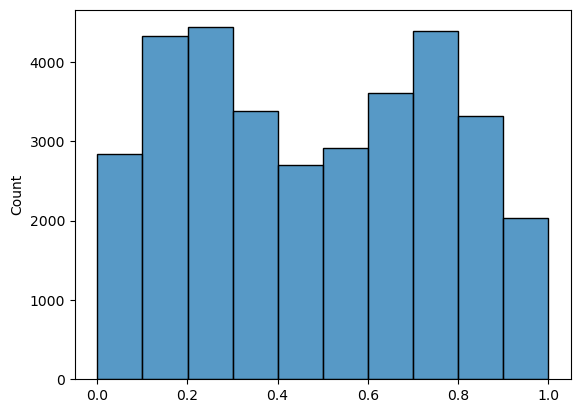

In [13]:
pred_pseudotime = []
model.eval()
model.to("cuda:7")

eval_data = dm.dataset[:]
batch_size = 100
for i in tqdm(range(0, len(eval_data), batch_size), desc="Computing pseudotime", total=len(eval_data) // batch_size):
    batch = eval_data[i:i+batch_size]
    x, y = batch
    print(x.shape, y.shape)
    x = x.to("cuda:7")
    theta_pred = model(x)
    y_pred = theta_pred.remainder(2 * torch.pi) / (2 * torch.pi)
    pred_pseudotime.append(y_pred.detach().cpu())
pred_pseudotime = torch.cat(pred_pseudotime, dim=0).flatten().numpy()
sns.histplot(pred_pseudotime, bins=10)
print(pred_pseudotime.shape)
np.save(DATA_DIR / f"FUCCI_pseudotime_pred_{NAME}.npy", pred_pseudotime)

  0%|          | 0/1 [00:00<?, ?it/s]

torch.Size([6786, 1664]) torch.Size([6786])


100%|██████████| 1/1 [00:00<00:00,  1.53it/s]


(6786,)


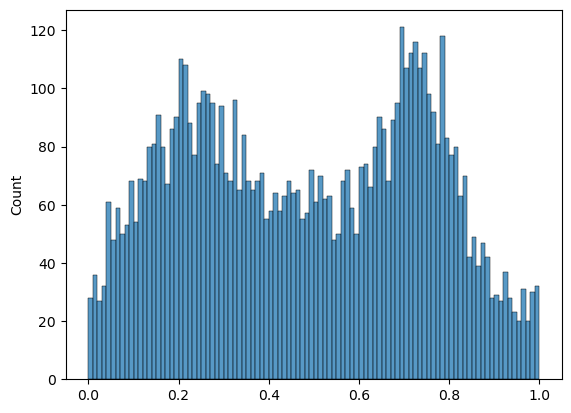

In [14]:
pred_pseudotime_test = []
model.eval()
model.to("cuda:7")

eval_data = dm.dataset[dm.split_indices["test"]]

for i in tqdm(range(0, len(eval_data), batch_size)):
    batch = eval_data[i:i+batch_size]
    x, y = batch
    print(x.shape, y.shape)
    x = x.to("cuda:7")
    theta_pred = model(x)
    y_pred = theta_pred.remainder(2 * torch.pi) / (2 * torch.pi)
    # y_pred = theta_pred.clamp(0, 2 * np.pi) / (2 * np.pi)
    pred_pseudotime_test.append(y_pred.detach().cpu())
pred_pseudotime_test = torch.cat(pred_pseudotime_test, dim=0).flatten().numpy()
sns.histplot(pred_pseudotime_test, bins=100)
print(pred_pseudotime_test.shape)

(201,)
(6786,)
0 199


<Axes: ylabel='Count'>

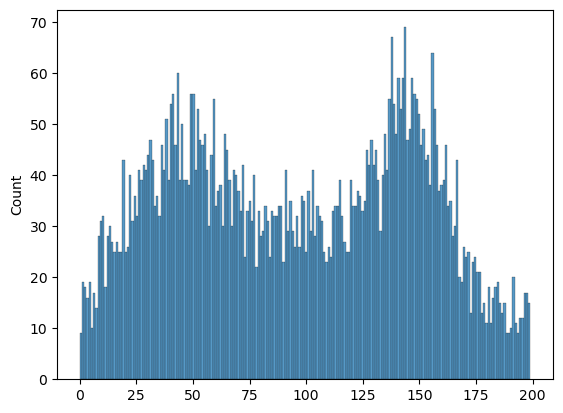

In [15]:
# pred_pseudotime = fucci_time_test
plt.clf()
plt.close()
bin_count = 200
bins = np.linspace(0, 1 + 1e-5, bin_count + 1)
print(bins.shape)
binned_pred_pseudotime_test = np.digitize(pred_pseudotime_test, bins) - 1
print(binned_pred_pseudotime_test.shape)
print(binned_pred_pseudotime_test.min(), binned_pred_pseudotime_test.max())
sns.histplot(binned_pred_pseudotime_test, bins=bin_count)

Text(0, 0.5, 'Intensity')

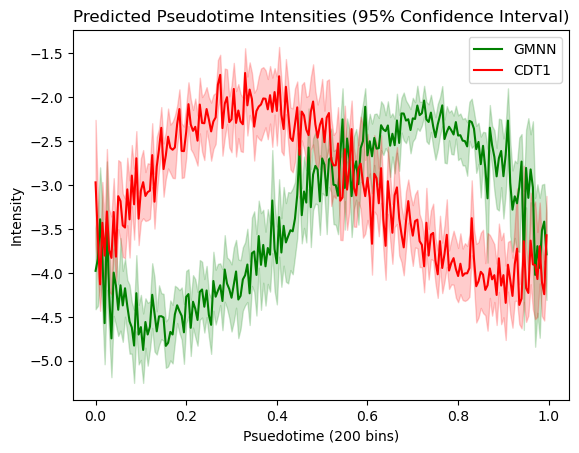

In [16]:
df = pd.DataFrame(np.concatenate((log_intensities_test[:, 2:], binned_pred_pseudotime_test[:, None] / bin_count), axis=1), columns=["GMNN", "CDT1", "Pseudotime"])
ci = True
interval = 95
sns.lineplot(data=df, x="Pseudotime", y="GMNN", errorbar=('ci' if ci else 'pi', interval), color="green", label="GMNN")
sns.lineplot(data=df, x="Pseudotime", y="CDT1", errorbar=('ci' if ci else 'pi', interval), color="red", label="CDT1")
plt.title(f"Predicted Pseudotime Intensities ({interval}% {'Confidence Interval' if ci else 'Percentile Interval'})")
plt.xlabel(f"Psuedotime ({bin_count} bins)")
plt.ylabel("Intensity")

Text(0, 0.5, 'Intensity (5 bin smoothing)')

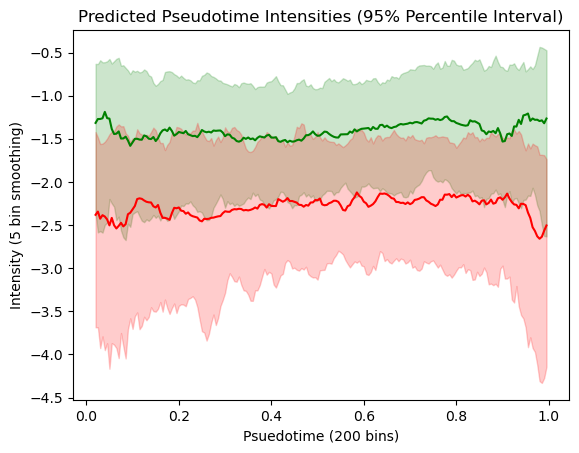

In [17]:
interval = 95
percentiles = [50 - interval / 2, 50, 50 + interval / 2]
pred_gmnn = np.zeros((bin_count, 3))
pred_cdt1 = np.zeros((bin_count, 3))
for i in range(0, bin_count):
    if len(log_intensities_test[binned_pred_pseudotime_test == i, 0]) == 0:
        pred_gmnn[i] = np.array([np.nan, np.nan, np.nan])
        pred_cdt1[i] = np.array([np.nan, np.nan, np.nan])
    else:
        pred_gmnn[i] = np.percentile(log_intensities_test[binned_pred_pseudotime_test == i, 0], percentiles)
        pred_cdt1[i] = np.percentile(log_intensities_test[binned_pred_pseudotime_test == i, 1], percentiles)

# plot moving average of 2.5, 50, and 97.5 percentiles with window size 10
window_size = 5
smoothed_pred_gmnn = np.zeros((bin_count - (window_size - 1), 3))
smoothed_pred_cdt1 = np.zeros((bin_count - (window_size - 1), 3))

for i in range(len(smoothed_pred_gmnn)):
    smoothed_pred_gmnn[i] = np.mean(pred_gmnn[i:i+window_size], axis=0)
    smoothed_pred_cdt1[i] = np.mean(pred_cdt1[i:i+window_size], axis=0)

smoothed_bins = bins[window_size - 1:-1]
plt.plot(smoothed_bins, smoothed_pred_gmnn[:, 1], label="GMNN", color="green")
plt.fill_between(smoothed_bins, smoothed_pred_gmnn[:, 0], smoothed_pred_gmnn[:, 2], alpha=0.2, color="green")
plt.plot(smoothed_bins, smoothed_pred_cdt1[:, 1], label="CDT1", color="red")
plt.fill_between(smoothed_bins, smoothed_pred_cdt1[:, 0], smoothed_pred_cdt1[:, 2], alpha=0.2, color="red")
plt.title(f"Predicted Pseudotime Intensities ({interval}% Percentile Interval)")
plt.xlabel(f"Psuedotime ({bin_count} bins)")
plt.ylabel(f"Intensity ({window_size} bin smoothing)")

# Confusion Matrix Generation

In [18]:
"""
M/G1  0: 0 to 0.09 or 0.98 to 1.0
G1    1: 0.09 to 0.39
G1/S  2: 0.39 to 0.65
G2    3: 0.65 to 0.98
"""
phase_binning = lambda x: torch.where(
    x < 0.09, torch.zeros_like(x),
    torch.where(
        x < 0.39, torch.ones_like(x),
        torch.where(
            x < 0.65, torch.ones_like(x) * 2,
            torch.where(
                x < 0.98, torch.ones_like(x) * 3,
                torch.zeros_like(x)
            )
        )
    )
)
preds_phase_binned_test = phase_binning(torch.tensor(pred_pseudotime_test))
labels_phase_binned_test = phase_binning(torch.tensor(fucci_time_test))
preds_phase_binned_test = torch.where(preds_phase_binned_test == 0, 0, preds_phase_binned_test - 1).numpy()
labels_phase_binned_test = torch.where(labels_phase_binned_test == 0, 0, labels_phase_binned_test - 1).numpy()

<Axes: >

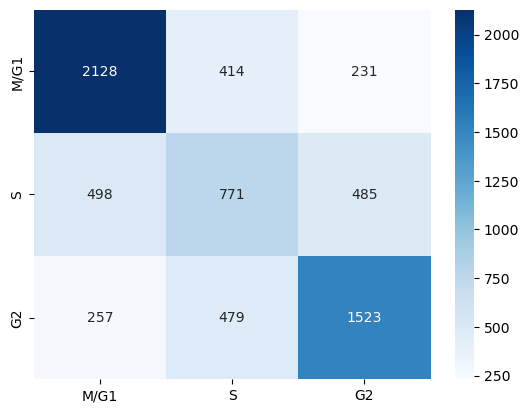

In [19]:
from sklearn.metrics import confusion_matrix
conf = confusion_matrix(labels_phase_binned_test, preds_phase_binned_test)
sns.heatmap(conf, annot=True, cmap="Blues", fmt="d", xticklabels=["M/G1", "S", "G2"], yticklabels=["M/G1", "S", "G2"])

# Probabilities for Predictions

In [20]:
# get predictions on training data
pseudotime_label_val = dm.val_dataloader().dataset[:][1].flatten().cpu().numpy()
log_intensities_val = log_intensities[dm.split_indices["val"]]
fucci_time_val = fucci_time[dm.split_indices["val"]].astype(np.float32)

if use_all:
    pseudotime_label_val = dm.dataset[:][1].flatten().cpu().numpy()
    log_intensities_val = log_intensities[:]
    fucci_time_val = fucci_time[:].astype(np.float32)
    print(len(log_intensities_val), len(fucci_time_val))


In [21]:
assert (fucci_time_val == pseudotime_label_val).all(), f"{np.where(fucci_time_val != pseudotime_label_val)}"

AssertionError: (array([   0,    1,    2, ..., 5426, 5427, 5428]),)

100%|██████████| 1/1 [00:00<00:00,  2.37it/s]

(0,)


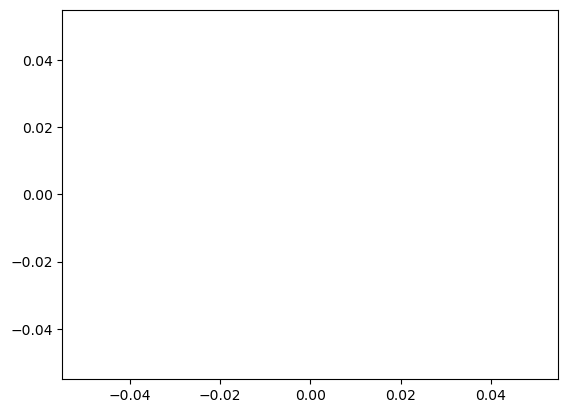

In [ ]:
pred_pseudotime_val = []
model.eval()
model.to("cuda:7")

eval_data = dm.dataset[dm.split_indices["val"]]
if use_all:
    eval_data = dm.dataset[:]

for i in tqdm(range(0, len(eval_data), batch_size)):
    batch = eval_data[i:i+batch_size]
    x, y = batch
    x = x.to("cuda:7")
    theta_pred = model(x)
    y_pred = theta_pred.remainder(2 * torch.pi) / (2 * torch.pi)
    pred_pseudotime_val.append(y_pred.detach().cpu())
pred_pseudotime_val = torch.cat(pred_pseudotime_val, dim=0).flatten().numpy()
sns.histplot(pred_pseudotime_val, bins=100)
print(pred_pseudotime_val.shape)

In [ ]:
# P(label)
label_val = phase_binning(torch.tensor(fucci_time_val))
label_val = torch.where(label_val == 0, 0, label_val - 1).int()
p_label = (torch.bincount(label_val) / len(label_val)).numpy()
print(p_label)

[]


ValueError: x and y must have same first dimension, but have shapes (100,) and (0,)

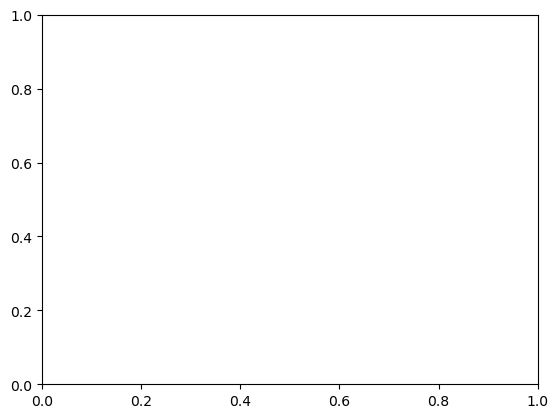

In [ ]:
# P(x)
disc_bins = np.linspace(0, 1, 101)
preds_disc = np.digitize(pred_pseudotime_val, disc_bins) - 1
p_x = np.bincount(preds_disc) / len(preds_disc)

plt.clf()
plt.plot(disc_bins[:-1], p_x)

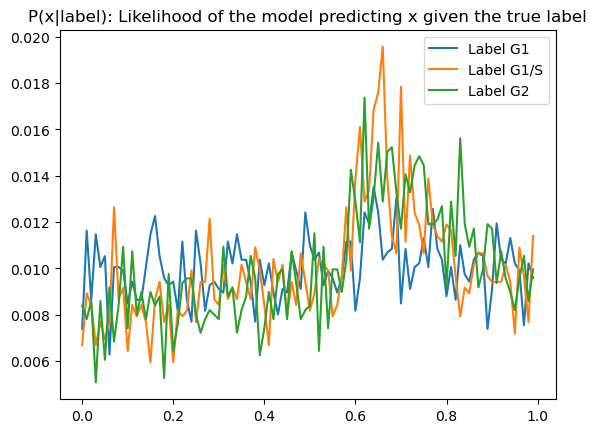

<function matplotlib.pyplot.show(close=None, block=None)>

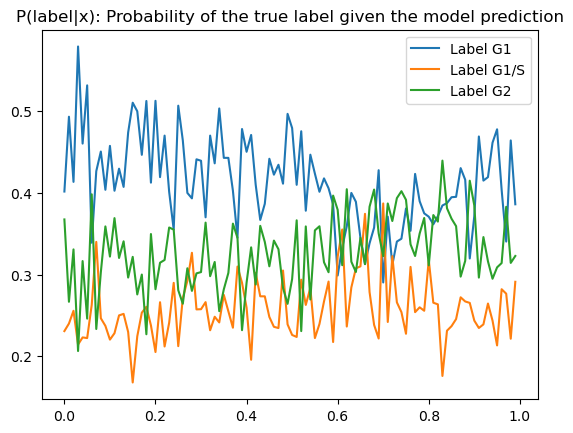

In [ ]:
# P(x|label)
label_names = ["G1", "G1/S", "G2"]
p_x_label = np.zeros((3, 100))
for i in range(3):
    p_x_label[i] = np.bincount(preds_disc[label_val == i], minlength=100) / len(preds_disc[label_val == i])
    plt.plot(disc_bins[:-1], p_x_label[i], label=f"Label {label_names[i]}")
plt.legend()
plt.title("P(x|label): Likelihood of the model predicting x given the true label")
plt.show()

# P(label|x)
plt.clf()
p_label_x = np.zeros((3, 100))
for i in range(3):
    p_label_x[i] = p_x_label[i] * p_label[i] / p_x
    plt.plot(disc_bins[:-1], p_label_x[i], label=f"Label {label_names[i]}")
plt.legend()
plt.title("P(label|x): Probability of the true label given the model prediction")
plt.show

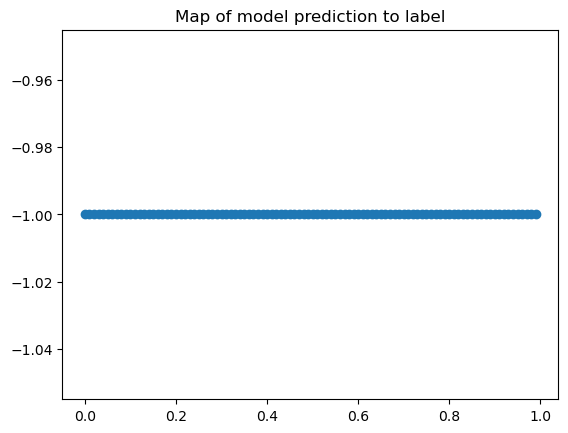

In [ ]:
# map labels to the pseudotime bins by finding the label in p_label_x that is > threshold and -1 otherwise
threshold = 0.70
bin_to_label = np.argmax(p_label_x, axis=0)
bin_to_label[p_label_x.max(axis=0) < threshold] = -1

plt.clf()
plt.scatter(disc_bins[:-1], bin_to_label)
plt.title("Map of model prediction to label")
plt.show()

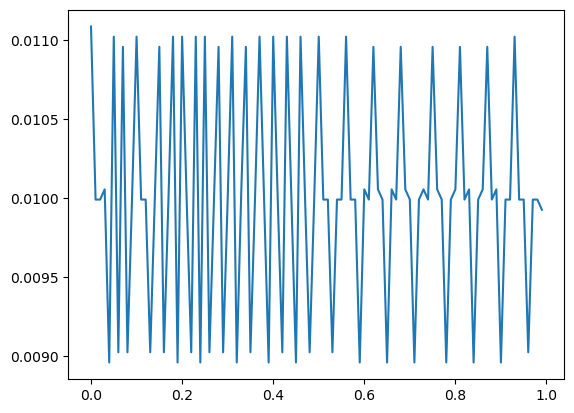

In [ ]:
# P(x_true)
labels_disc = np.digitize(fucci_time_val, disc_bins) - 1
p_x_true = np.bincount(labels_disc) / len(labels_disc)
plt.clf()
plt.plot(disc_bins[:-1], p_x_true)

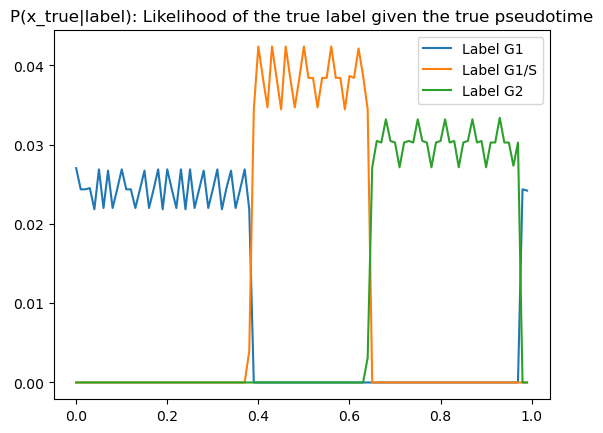

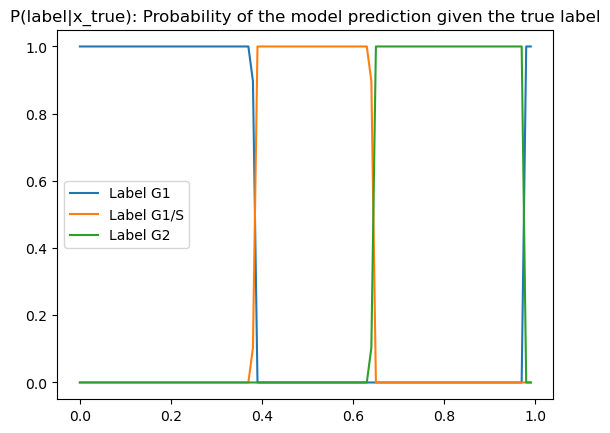

In [ ]:
# P(x_true|label)
label_names = ["G1", "G1/S", "G2"]
p_x_label = np.zeros((3, 100))
for i in range(3):
    p_x_label[i] = np.bincount(labels_disc[label_val == i], minlength=100) / len(labels_disc[label_val == i])
    plt.plot(disc_bins[:-1], p_x_label[i], label=f"Label {label_names[i]}")
plt.legend()
plt.title("P(x_true|label): Likelihood of the true label given the true pseudotime")
plt.show()

# P(label|x_true)
plt.clf()
p_label_x_true = np.zeros((3, 100))
for i in range(3):
    p_label_x_true[i] = p_x_label[i] * p_label[i] / p_x_true
    plt.plot(disc_bins[:-1], p_label_x_true[i], label=f"Label {label_names[i]}")
plt.legend()
plt.title("P(label|x_true): Probability of the model prediction given the true label")
plt.show()

In [ ]:
import pickle as pkl

# write P(label|x), P(x|label), P(x), P(label), etc. to a combined file as a dictionary of numpy arrays
probs = {"p_label_x": p_label_x, "p_x_label": p_x_label, "p_x": p_x, "p_label": p_label, "p_x_true": p_x_true, "p_label_x_true": p_label_x_true, "bins": disc_bins}
with open(DATA_DIR / f"FUCCI_pseudotime_probs_{NAME}.pkl", "wb") as f:
    pkl.dump(probs, f)

# ROC Curves

In [ ]:
probs = pkl.load(open(DATA_DIR / f"FUCCI_pseudotime_probs_{NAME}.pkl", "rb"))
# p_x_label = probs["p_x_label"]
# p_x = probs["p_x"]
# p_label = probs["p_label"]
p_label_x = probs["p_label_x"]
disc_bins = probs["bins"]

In [ ]:
preds_disc = np.digitize(pred_pseudotime_test, disc_bins) - 1
labels_phase_binned_test = labels_phase_binned_test

(3103, 3) (3103, 3)
Number of classes:  3


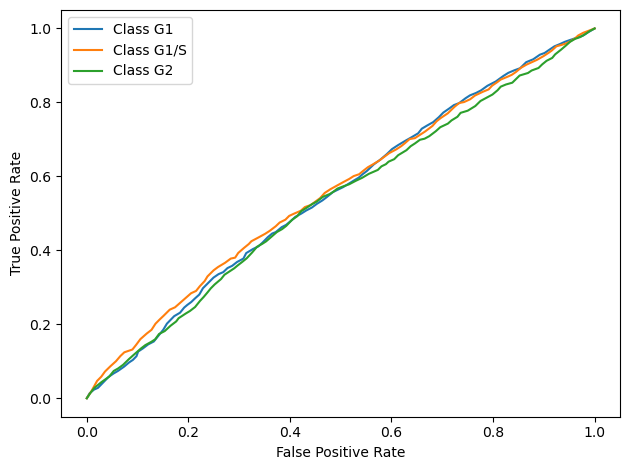

AUCs: 
Class G1: 0.5525202132560597
Class G1/S: 0.5612842640761638
Class G2: 0.539270978226762


In [ ]:
from sklearn.metrics import roc_curve

# assuming y_true is the true labels and y_pred_prob is the predicted probabilities for each class
# convert labels to one-hot encoding
n_classes = len(np.unique(labels_phase_binned_test)) # number of classes
y_true = np.eye(n_classes)[labels_phase_binned_test.astype(int)]
y_pred_prob = p_label_x.T[preds_disc]
print(y_true.shape, y_pred_prob.shape)
print("Number of classes: ", n_classes)
roc_curves = [] # list to store the ROC curves for each class

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_pred_prob[:, i])
    roc_curves.append((fpr, tpr))

for i in range(n_classes):
    fpr, tpr = roc_curves[i]
    plt.plot(fpr, tpr, label=f"Class {label_names[i]}")
plt.legend()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.tight_layout()
plt.show()

print("AUCs: ")
for i in range(n_classes):
    fpr, tpr = roc_curves[i]
    auc = np.trapz(tpr, fpr)
    print(f"Class {label_names[i]}: {auc}")

# Ideal Model Performance

In [ ]:
# lineplot of the true pseudotime for each channel with 75% percentile intervals
log_intensities = np.load(DATA_DIR / f"FUCCI_log_intensity_labels_{NAME}.npy")
fucci_time = np.load(DATA_DIR / f"FUCCI_pseudotime_{NAME}.npy")

df = pd.DataFrame(np.concatenate((log_intensities, fucci_time[:, None]), axis=1), columns=["GMNN", "CDT1", "Pseudotime"])

plt.clf()
plt.figure(figsize=(10, 10))
sns.lineplot(data=df, x="Pseudotime", y="GMNN", errorbar=('pi', 75), color="green")
sns.lineplot(data=df, x="Pseudotime", y="CDT1", errorbar=('pi', 75), color="red")
plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/data/ishang/FUCCI-dataset-well/FUCCI_log_intensity_labels_unnormalize_1250_sharp_512_crop_og_res.npy'

<Figure size 640x480 with 0 Axes>

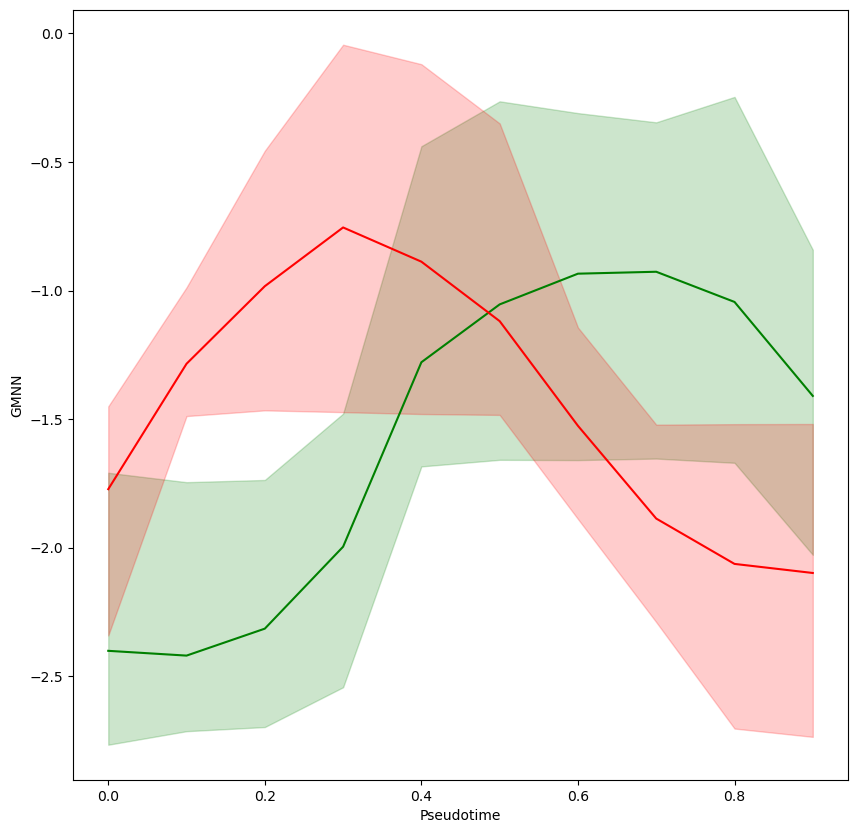

In [ ]:
# now plot it but with the pseudotime binned into 10 buckets
bin_count = 10
bins = np.linspace(0, 1 + 1e-5, bin_count + 1)
binned_fucci_time = np.digitize(fucci_time, bins) - 1

df = pd.DataFrame(np.concatenate((log_intensities, binned_fucci_time[:, None] / bin_count), axis=1), columns=["GMNN", "CDT1", "Pseudotime"])

plt.clf()
plt.figure(figsize=(10, 10))
sns.lineplot(data=df, x="Pseudotime", y="GMNN", errorbar=('pi', 100), color="green")
sns.lineplot(data=df, x="Pseudotime", y="CDT1", errorbar=('pi', 100), color="red")
plt.show()

<Figure size 640x480 with 0 Axes>

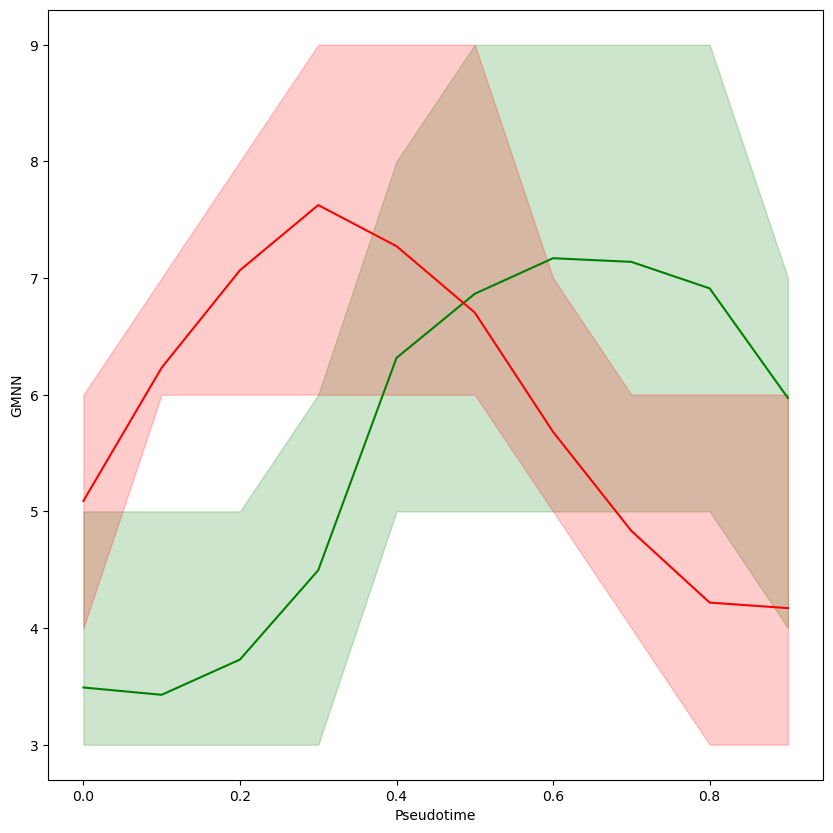

In [ ]:
# now bin the intensities too, and plot the mean and 100% percentile intervals
intensity_bins = 20
intensity_bins = np.linspace(-4, 4, intensity_bins + 1)
binned_log_intensities = np.digitize(log_intensities, intensity_bins) - 1

bin_count = 10
bins = np.linspace(0, 1 + 1e-5, bin_count + 1)
binned_fucci_time = np.digitize(fucci_time, bins) - 1

df = pd.DataFrame(np.concatenate((binned_log_intensities, binned_fucci_time[:, None] / bin_count), axis=1), columns=["GMNN", "CDT1", "Pseudotime"])

plt.clf()
plt.figure(figsize=(10, 10))
sns.lineplot(data=df, x="Pseudotime", y="GMNN", errorbar=('pi', 100), color="green")
sns.lineplot(data=df, x="Pseudotime", y="CDT1", errorbar=('pi', 100), color="red")
plt.show()

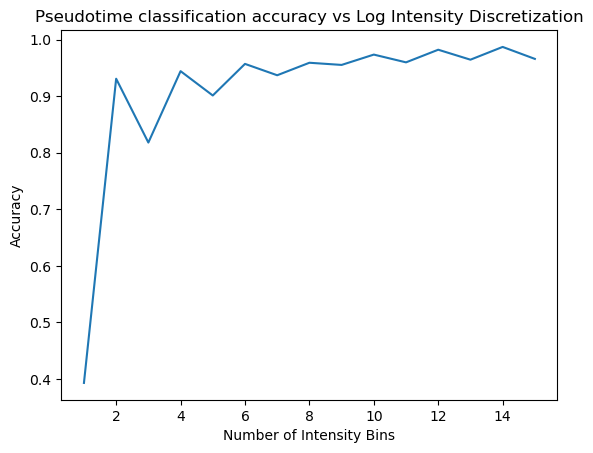

In [ ]:
# make classifier for log intensities to predict pseudotime bins using an MLE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# split into train and test
log_intensities = np.load(DATA_DIR / f"FUCCI_log_intensity_labels_{NAME}.npy")
fucci_time = np.load(DATA_DIR / f"FUCCI_pseudotime_{NAME}.npy")
# bin_count = 3
# bins = np.linspace(0, 1 + 1e-5, bin_count + 1)
bins = np.asarray([0, 0.39, 0.65, 1+1e-5])
binned_fucci_time = np.digitize(fucci_time, bins) - 1

def ideal_model_perf(int_bin_count):
    intensity_bins = np.linspace(-3, 0, int_bin_count + 1)
    binned_log_intensities = np.digitize(log_intensities, intensity_bins) - 1

    X_train, X_test, y_train, y_test = train_test_split(binned_log_intensities, binned_fucci_time, test_size=0.5, random_state=42)

    # train classifier
    clf = LogisticRegression(random_state=0).fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # get confusion matrix
    y_pred = clf.predict(X_test)
    conf = confusion_matrix(y_test, y_pred)
    return score, conf, clf

scores = []
int_bins_range = list(range(1, 16))
for int_bin_count in int_bins_range:
    score, conf, clf = ideal_model_perf(int_bin_count)
    scores.append(score)

plt.clf()
plt.plot(int_bins_range, scores)
plt.title("Pseudotime classification accuracy vs Log Intensity Discretization")
plt.xlabel("Number of Intensity Bins")
plt.ylabel("Accuracy")
plt.show()

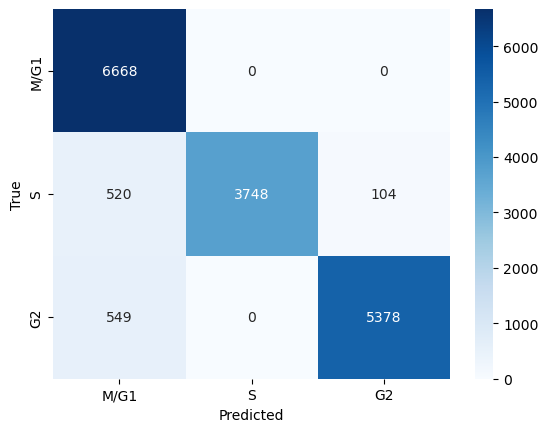

P(label|x):
M/G1	S	G2
[[0.86183275 0.         0.        ]
 [0.06720951 1.         0.01897118]
 [0.07095774 0.         0.98102882]]


In [ ]:
score, conf, clf = ideal_model_perf(2)
plt.clf()
sns.heatmap(conf, annot=True, cmap="Blues", fmt="d", xticklabels=["M/G1", "S", "G2"], yticklabels=["M/G1", "S", "G2"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# columns of the confusion matrix show the probabilities of the true label given the predicted label
print("P(label|x):")
print("M/G1\tS\tG2")
print(conf / np.sum(conf, axis=0))